In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

os.chdir("/wynton/group/capra/projects/modern_human_3Dgenome")

BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data.
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
#COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")

In [2]:
BASE_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome'

In [3]:
# Function for custom colormaps, from
# https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

import matplotlib.colors as mcolors

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def one_comparison_parse(ind1, ind2, matrix_seq, dict_seq, windows ):
    df = pd.read_csv(f"{seqComps_dir}/SeqComps_{ind1}_vs_{ind2}.txt", sep="\t", index_col=[0,1])
    df = df.loc[windows.index]
    avg = 1-df['seqComp_raw'].astype('float').mean()
    matrix_seq.loc[ind1,ind2] = avg
    matrix_seq.loc[ind2,ind1] = avg
    for w in windows.index:
        window_seq_diff = 1-float(df.loc[w]['seqComp_raw'])
        dict_seq[w].loc[ind1,ind2] = window_seq_diff
        dict_seq[w].loc[ind2,ind1] = window_seq_diff

    return matrix_seq, dict_seq

def one_comparison_parse_3d(ind1, ind2, matrix_3d, dict_3d, windows ):

    df = pd.read_csv(f"{Comps3d_dir}/3dcomp_{ind1}_vs_{ind2}.txt", sep="\t", index_col=[0,1])
    df = df.loc[windows.index]
    avg = (1-df['spearman'].astype('float')).mean()
    matrix_3d.loc[ind1,ind2] = avg
    matrix_3d.loc[ind2,ind1] = avg
    for w in windows.index:
        window_3d_diff = 1-float(df.loc[w]['spearman'])
        dict_3d[w].loc[ind1,ind2] = window_3d_diff
        dict_3d[w].loc[ind2,ind1] = window_3d_diff

    return matrix_3d, dict_3d

def get_window_dendrogram(w):
    plt.figure(figsize=(25,5))
    dg = sch.dendrogram(tree_complete[w][0], show_leaf_counts=True, labels=idx, leaf_font_size=10)
    plt.title(str(w))
    return dg

In [4]:
# Create pickle data structures for sequence and 3D by window
# Comps3d_dir = "/wynton/group/capra/projects/modern_human_3Dgenome/data/pairwise/subsample"
# count = 0
# dict_3d = {k: pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float') for k in windows.index} # takes about  50 sec
# matrix_3d = pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float')
# for i in comp_list.index: # 3 minutes per 50 iterations, 503 minutes total, 8 hours
#     ind1 = comp_list.loc[i]['ind1']
#     ind2 = comp_list.loc[i]['ind2']
#     matrix_3d, dict_3d = one_comparison_parse_3d(ind1, ind2, matrix_3d, dict_3d, windows)
#     count +=1 
#     if count%50 == 0:
#         print(count)

# pickle.dump( dict_3d, open( "dict_3d.p", "wb" ) )
# pickle.dump( matrix_3d, open( "matrix_3d.p", "wb" ) )

# seqComps_dir = "/wynton/group/capra/projects/modern_human_3Dgenome/data/pairwise/sequence/1KGvs1KG"
# count = 0
# dict_seq = {k: pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float') for k in windows.index} # takes about  50 sec
# matrix_seq = pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float')
# for i in comp_list.index: # 3 minutes per 50 iterations, 503 minutes total, 8 hours
#     ind1 = comp_list.loc[i]['ind1']
#     ind2 = comp_list.loc[i]['ind2']
#     matrix_seq, dict_seq = one_comparison_parse(ind1, ind2, matrix_seq, dict_seq, windows)
#     count +=1 
#     if count%50 == 0:
#         print(count)

# pickle.dump( dict_seq, open( "dict_seq.p", "wb" ) )
# pickle.dump( matrix_seq, open( "matrix_seq.p", "wb" ) )

In [5]:
comp_list = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_genomewide_averages.csv',
                       index_col=0)
all_indivs = list(set(comp_list.ind1.unique()) | set(comp_list.ind2.unique()))
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "dict_seq.p", "rb" ) )
matrix_seq = pickle.load( open( "matrix_seq.p", "rb" ) )

dict_3d = pickle.load( open( "dict_3d.p", "rb" ) )
matrix_3d = pickle.load( open( "matrix_3d.p", "rb" ) )


In [6]:

def one_window_tree(dict3d, w, tree_summary, tree_complete, link_method):
        window_df = dict_3d[w]
        idx = sorted(set(window_df.index).union(window_df.columns))
        length = len(idx)
        array = window_df.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
        condensed = array[np.triu_indices(length, k = 1)]
        Z = sch.linkage(condensed, method = link_method)
        dendrogram = sch.dendrogram(Z)
        whole_tree = [Z, dendrogram]

        cluster_sample_IDs = dendrogram['leaves']
        cluster_IDs = dendrogram['leaves_color_list']
        clusters_dict = dict(zip(cluster_sample_IDs, cluster_IDs))

        cluster_IDs_list = []
        for key, value in sorted(clusters_dict.items()):
                cluster_IDs_list.append(value)

        top_tree_y = dendrogram['dcoord'][-1]
        window_stats = cluster_IDs_list + top_tree_y


        return window_stats, whole_tree

In [7]:
windows_tuples = list(dict_3d.keys())

In [8]:
windows_tuples

[('chr1', 1048576),
 ('chr1', 1572864),
 ('chr1', 3145728),
 ('chr1', 3670016),
 ('chr1', 4194304),
 ('chr1', 4718592),
 ('chr1', 5242880),
 ('chr1', 5767168),
 ('chr1', 6291456),
 ('chr1', 6815744),
 ('chr1', 7340032),
 ('chr1', 7864320),
 ('chr1', 8388608),
 ('chr1', 8912896),
 ('chr1', 9437184),
 ('chr1', 9961472),
 ('chr1', 10485760),
 ('chr1', 11010048),
 ('chr1', 11534336),
 ('chr1', 13107200),
 ('chr1', 13631488),
 ('chr1', 14155776),
 ('chr1', 14680064),
 ('chr1', 15204352),
 ('chr1', 15728640),
 ('chr1', 17301504),
 ('chr1', 17825792),
 ('chr1', 18350080),
 ('chr1', 18874368),
 ('chr1', 19398656),
 ('chr1', 19922944),
 ('chr1', 20447232),
 ('chr1', 20971520),
 ('chr1', 21495808),
 ('chr1', 22020096),
 ('chr1', 22544384),
 ('chr1', 23068672),
 ('chr1', 23592960),
 ('chr1', 24117248),
 ('chr1', 24641536),
 ('chr1', 25165824),
 ('chr1', 25690112),
 ('chr1', 26214400),
 ('chr1', 26738688),
 ('chr1', 27262976),
 ('chr1', 27787264),
 ('chr1', 28311552),
 ('chr1', 29884416),
 ('chr1'

0
100
200


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


300
400
500
600
700
800
900
1000


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


1100
1200
1300
1400
1500
1600


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


2900
3000
3100
3200
3300
3400


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


3500
3600
3700
3800
3900
4000
4100
4200
4300


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


4400


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


4500


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


4600
4700
4800


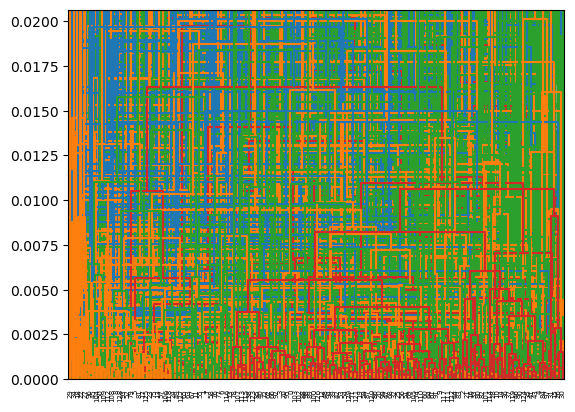

In [9]:
tree_summary = {}
tree_complete = {}

#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete')
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)

In [10]:
window_df = dict_3d[('chr1', 1048576)]
idx = sorted(set(window_df.index).union(window_df.columns))

In [11]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=idx + ['coord_0','coord_1','coord_2','coord_3'])


In [12]:
dataframe.coord_1.describe()

count    4873.000000
mean        0.028904
std         0.052083
min         0.000000
25%         0.005783
50%         0.012656
75%         0.029832
max         0.731198
Name: coord_1, dtype: float64

In [13]:
over_point5 = dataframe[dataframe.coord_1 > 0.5]

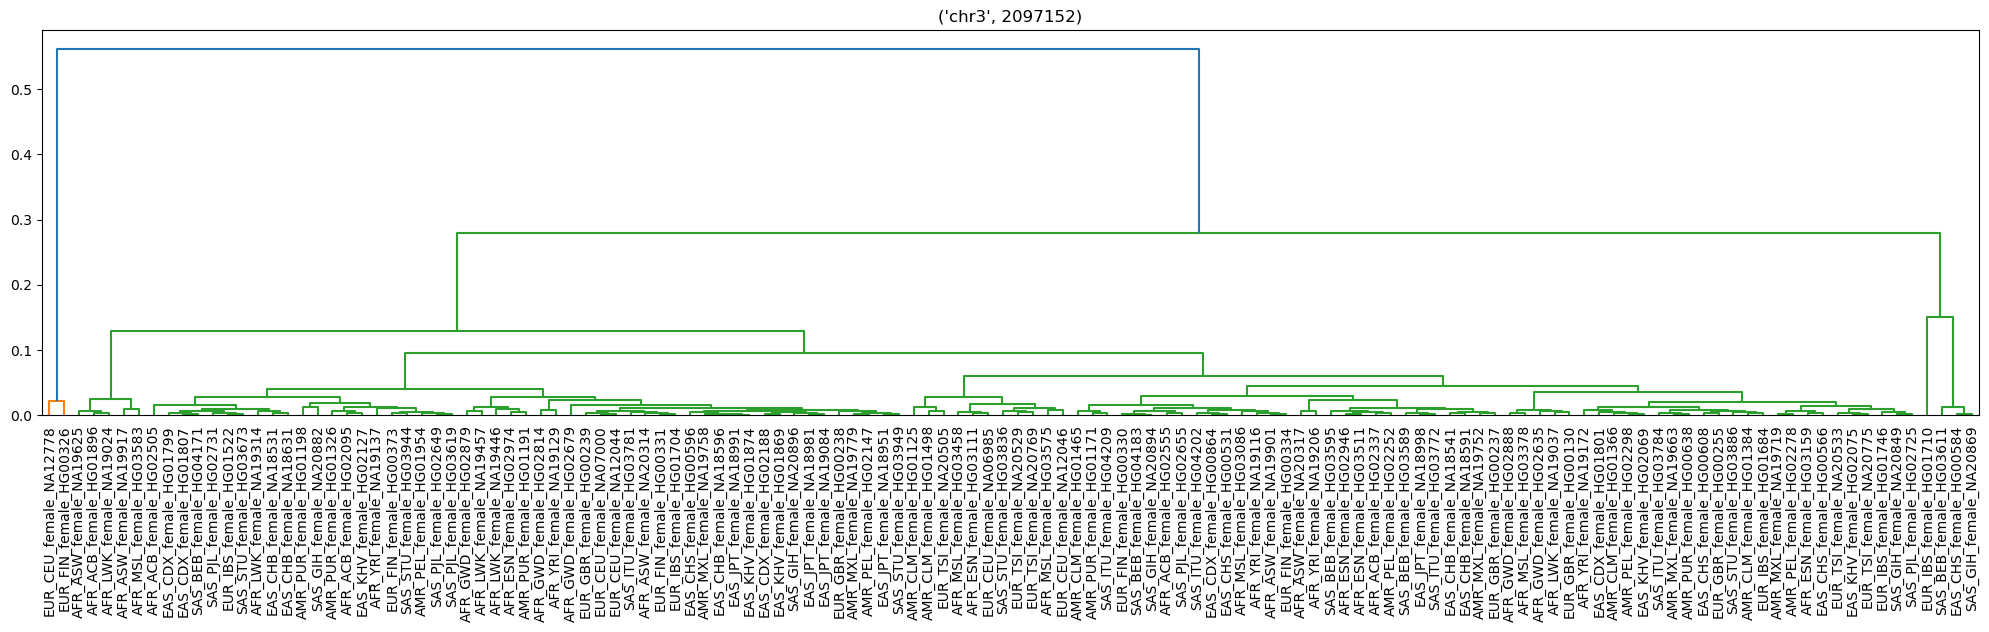

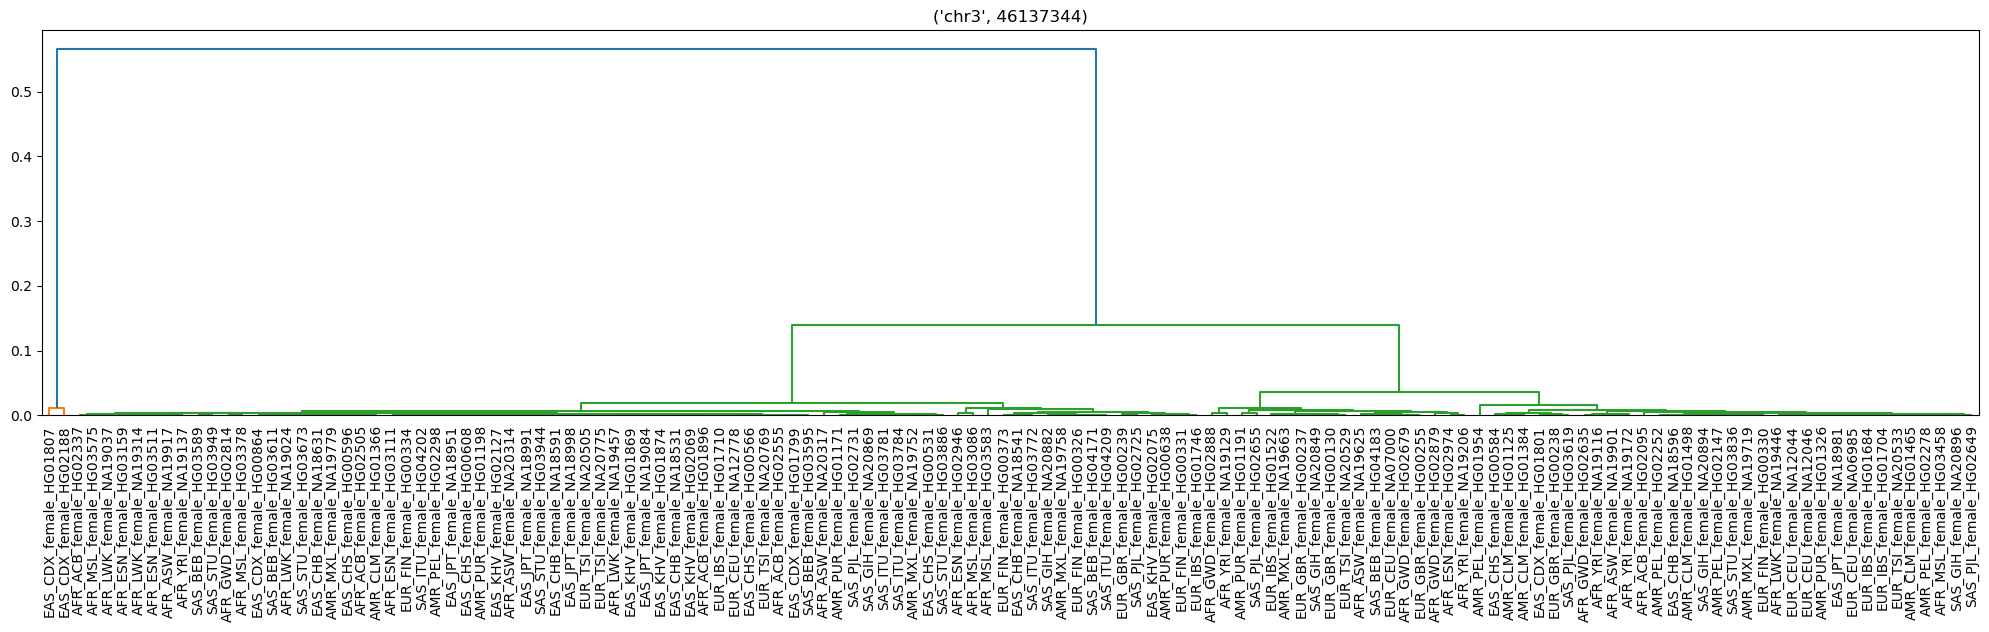

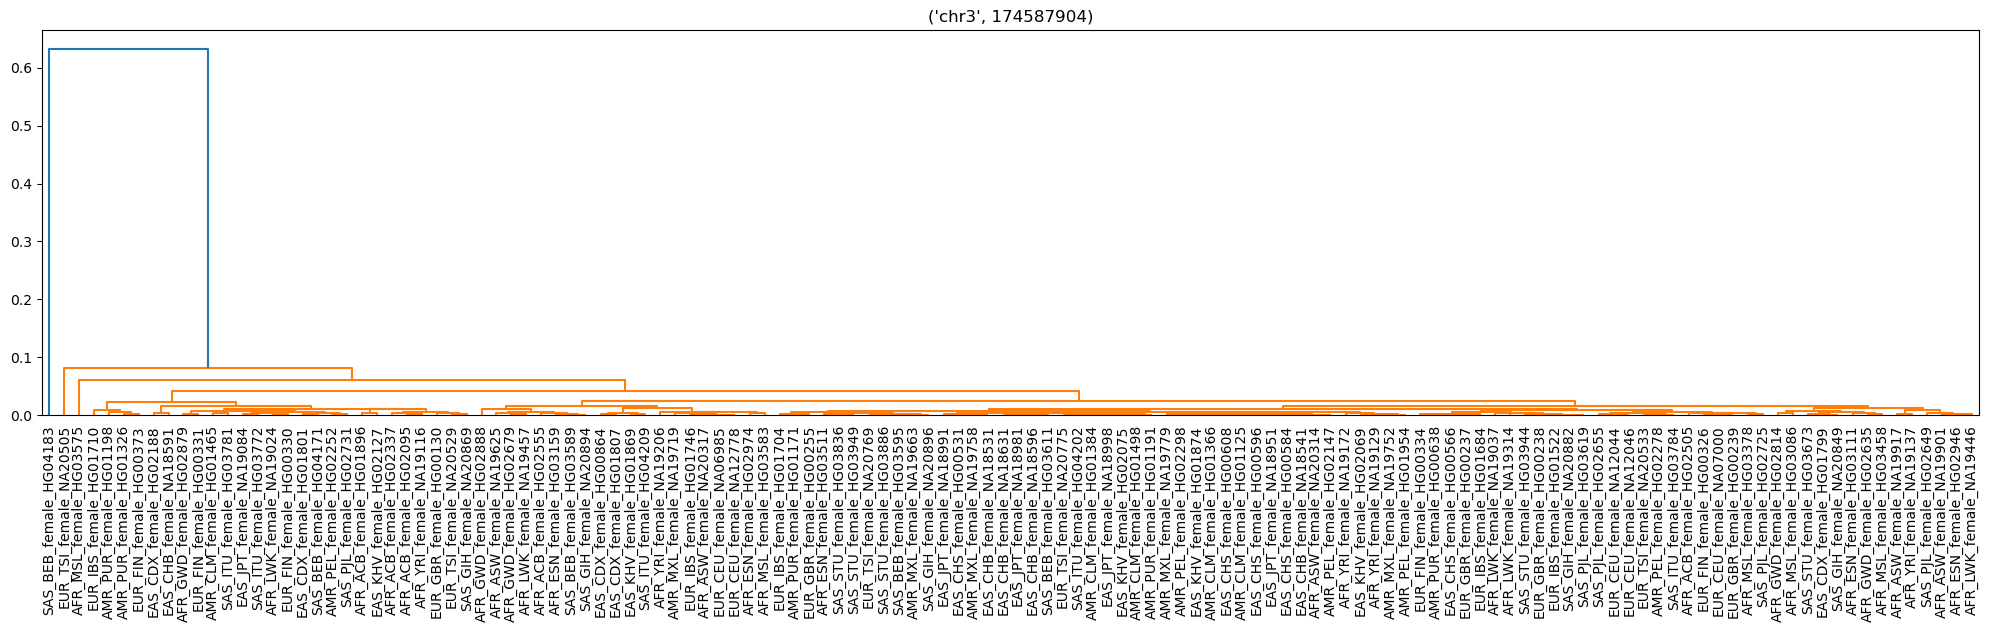

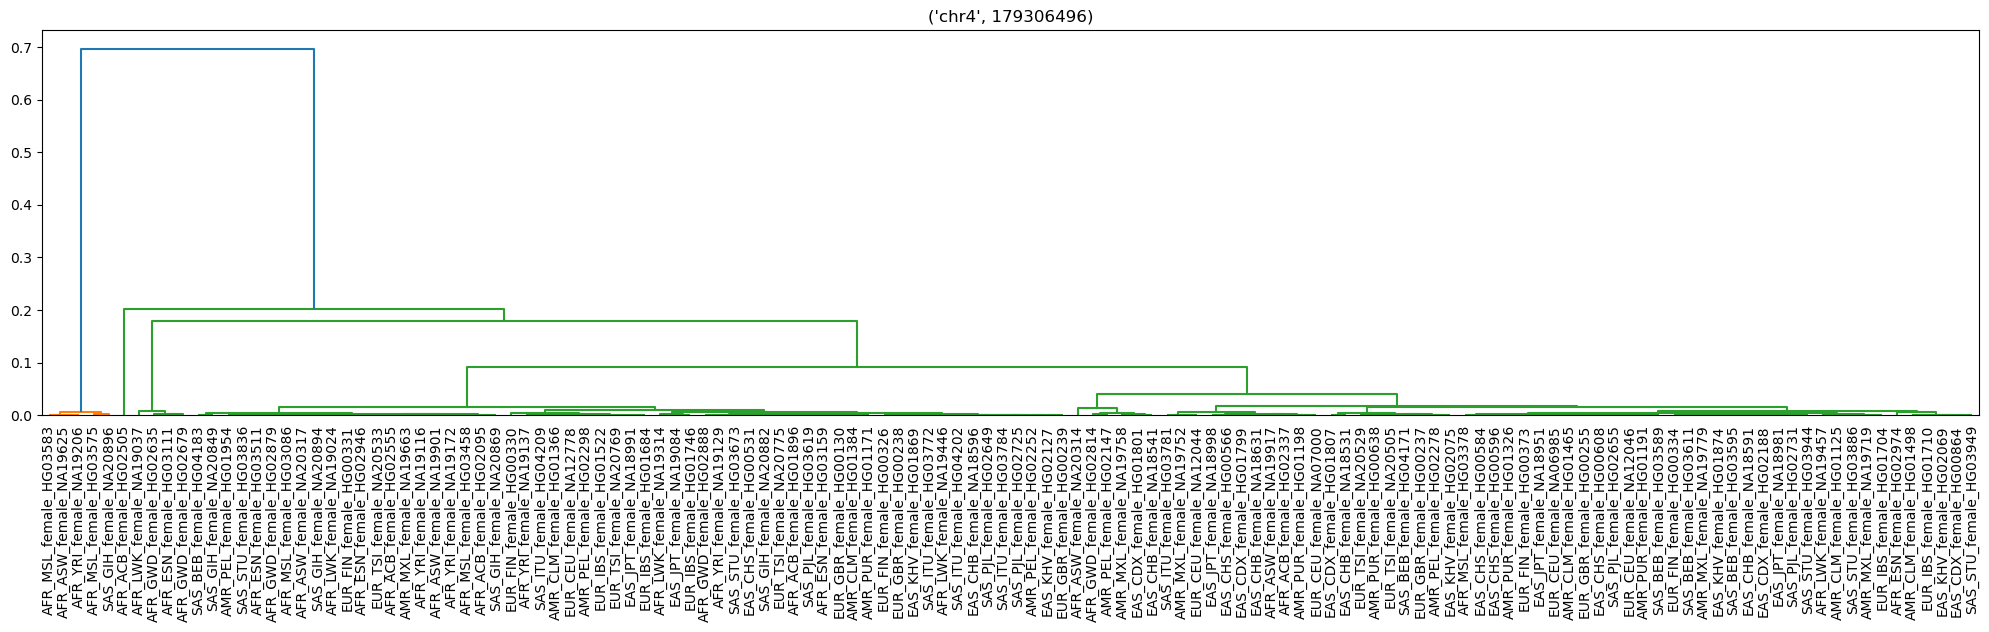

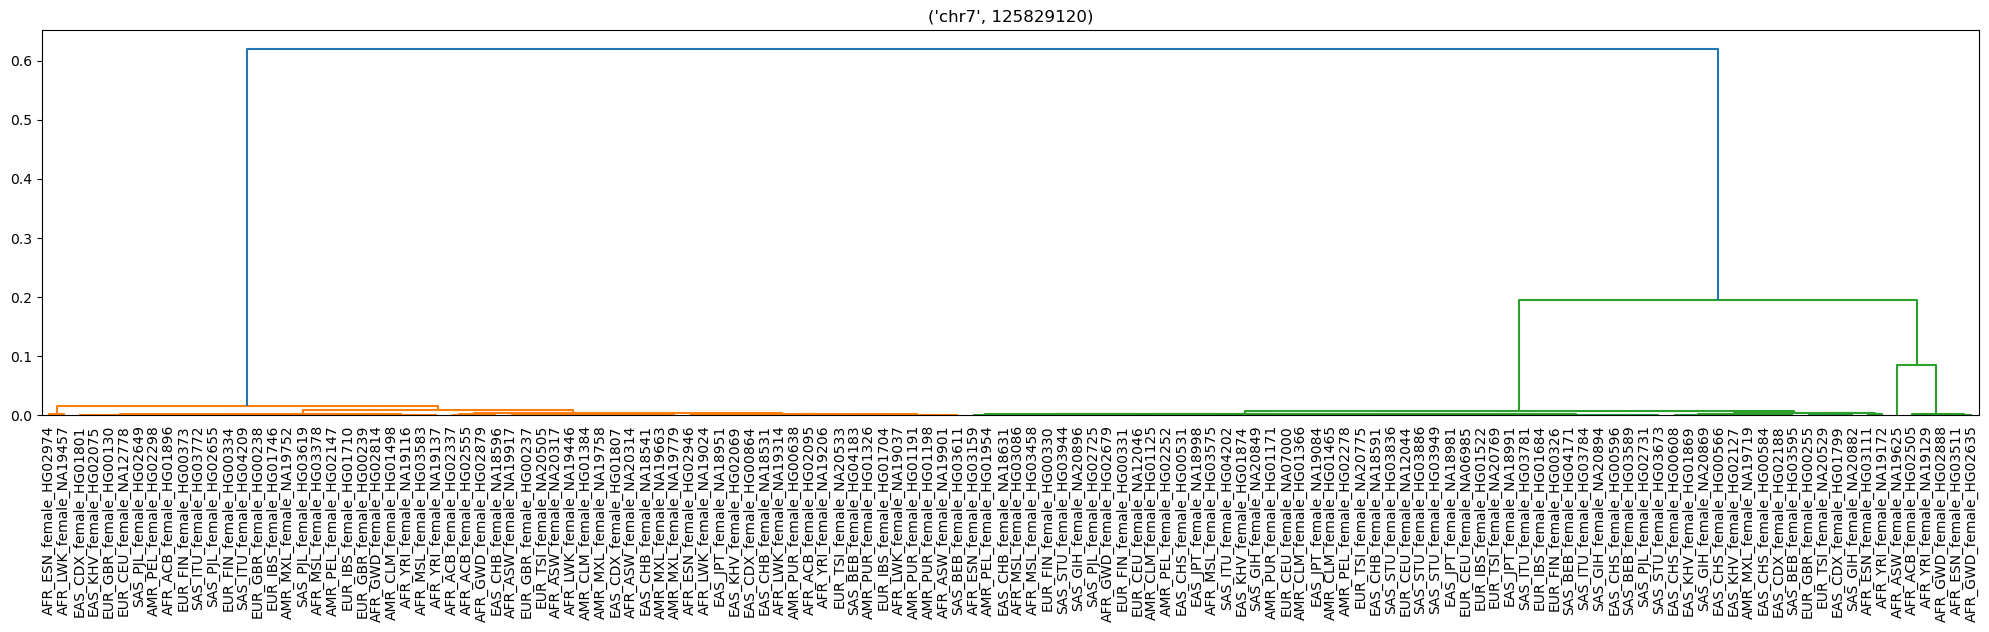

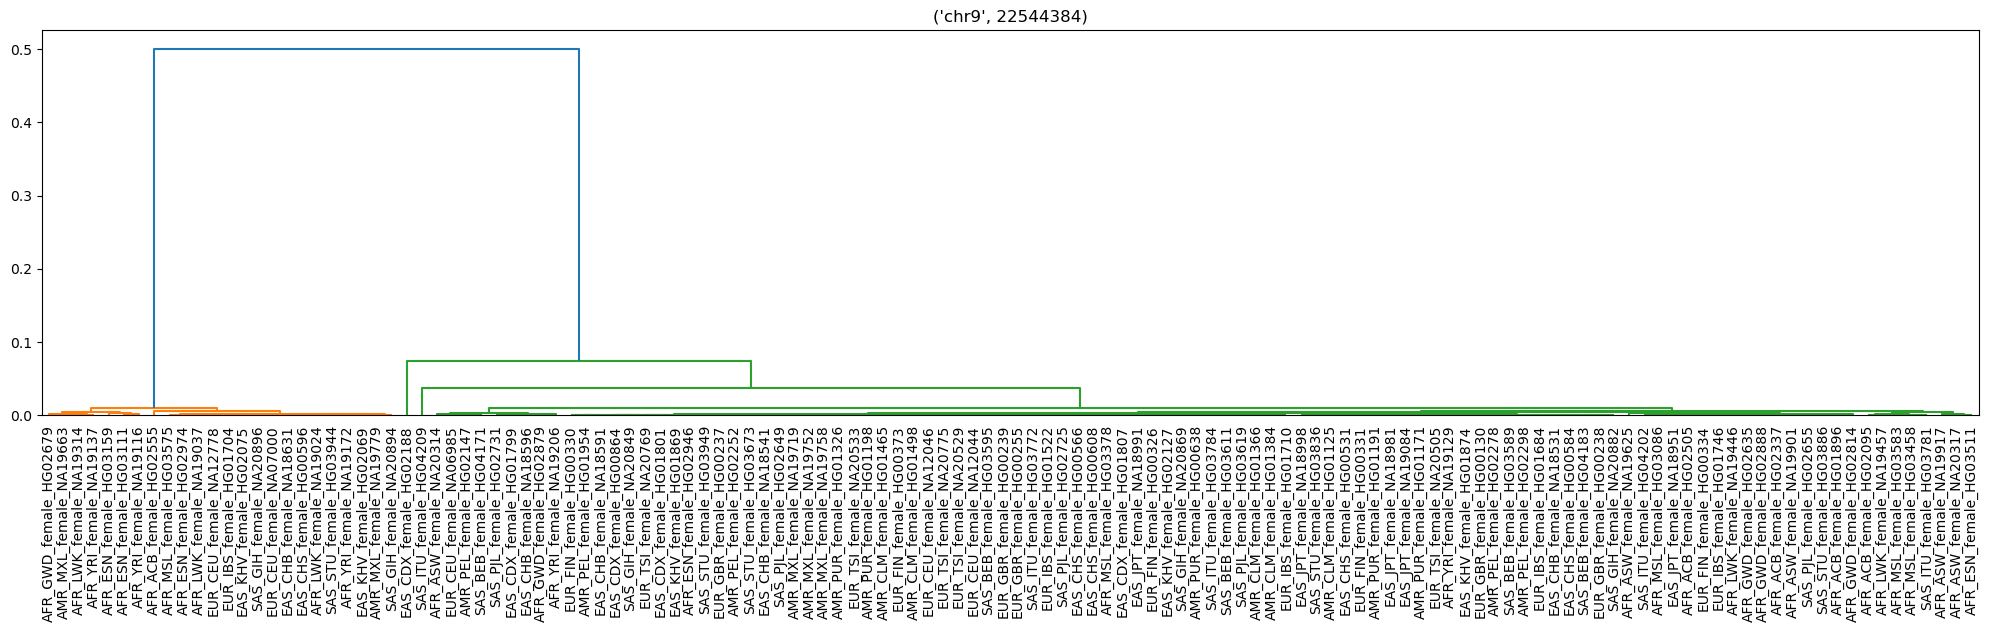

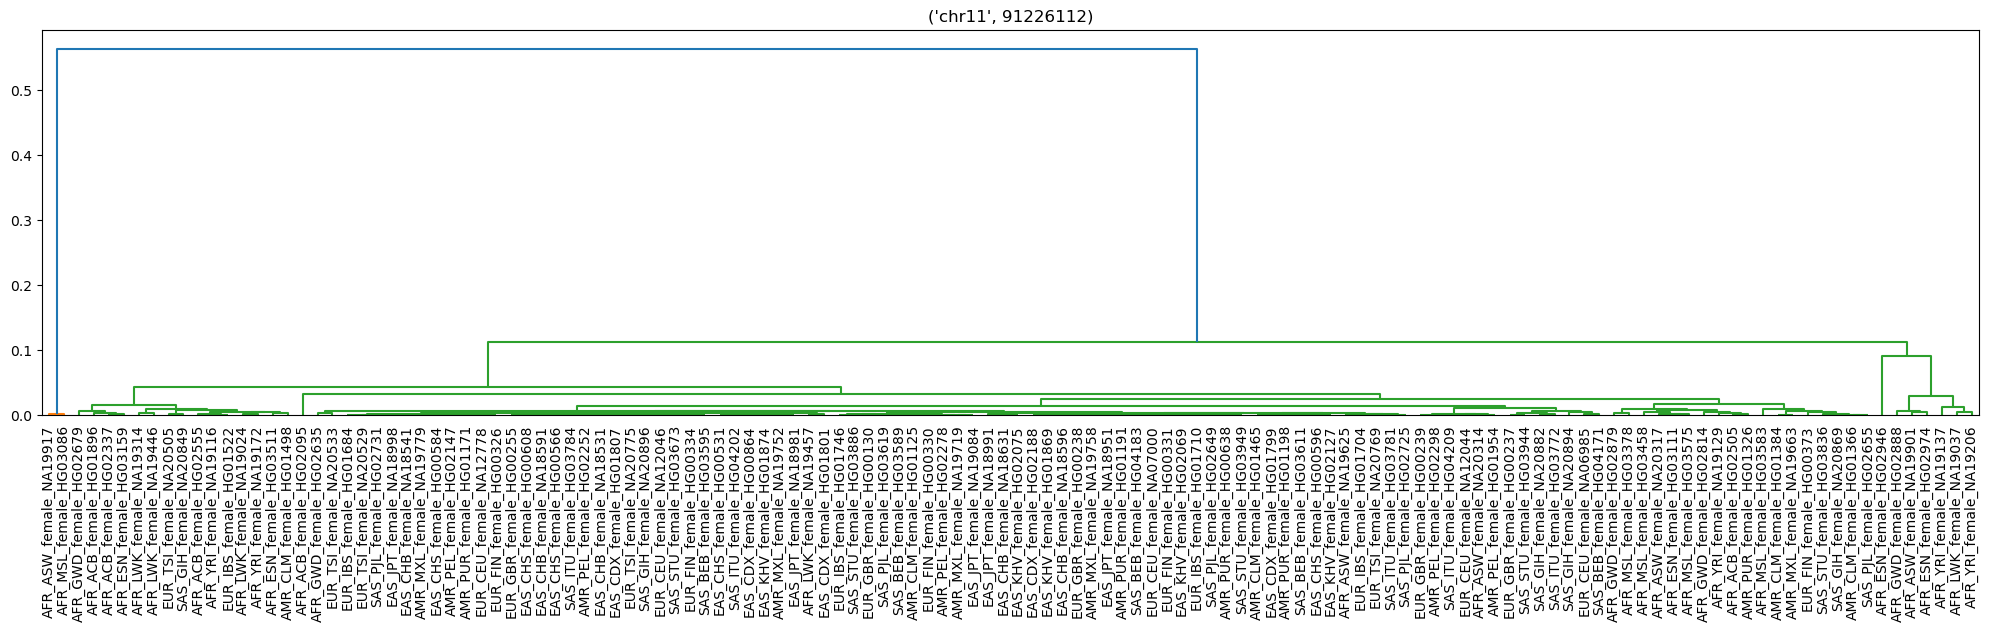

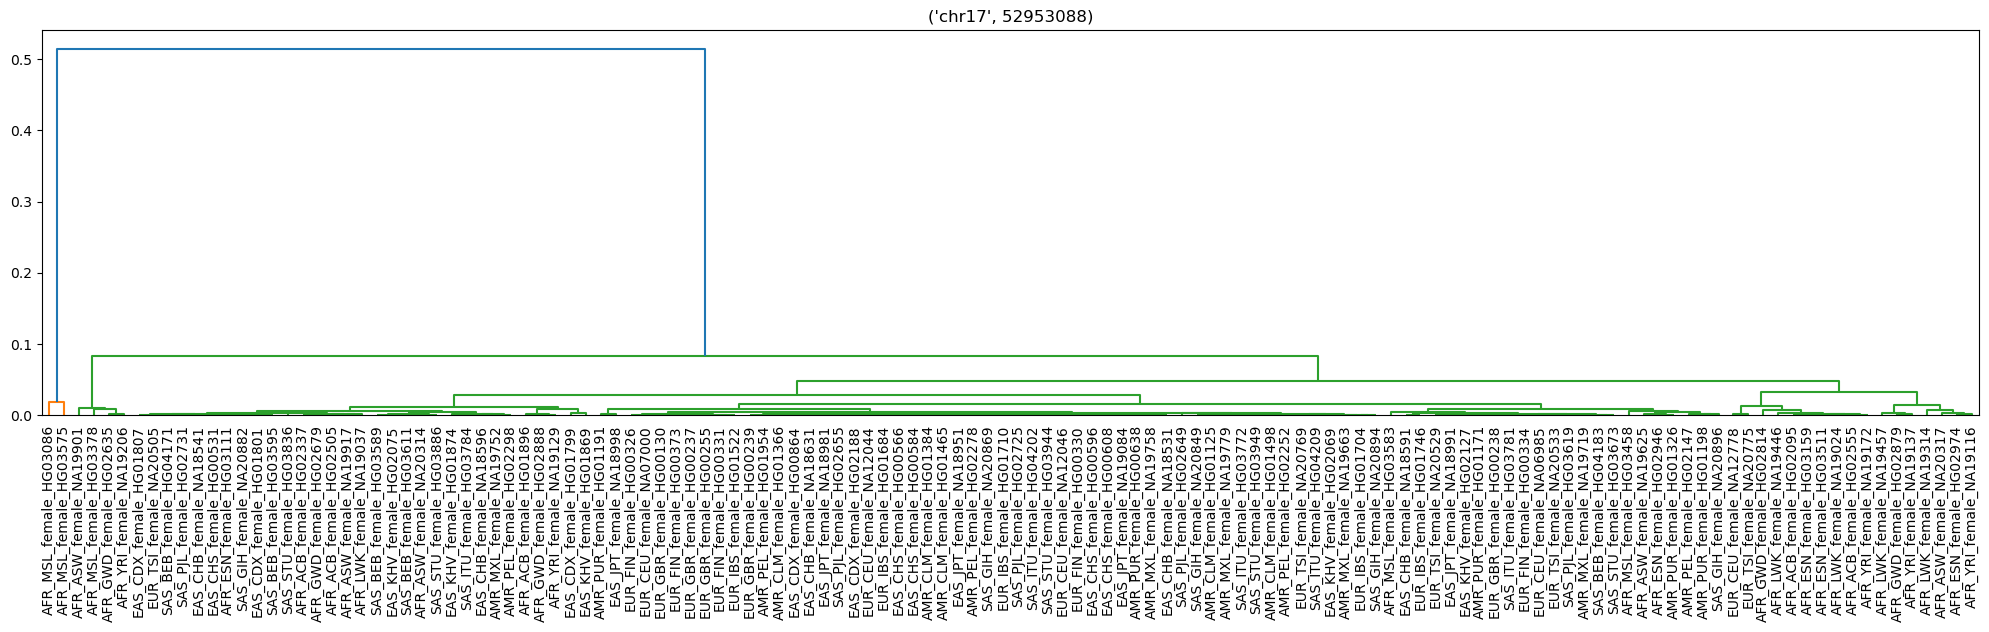

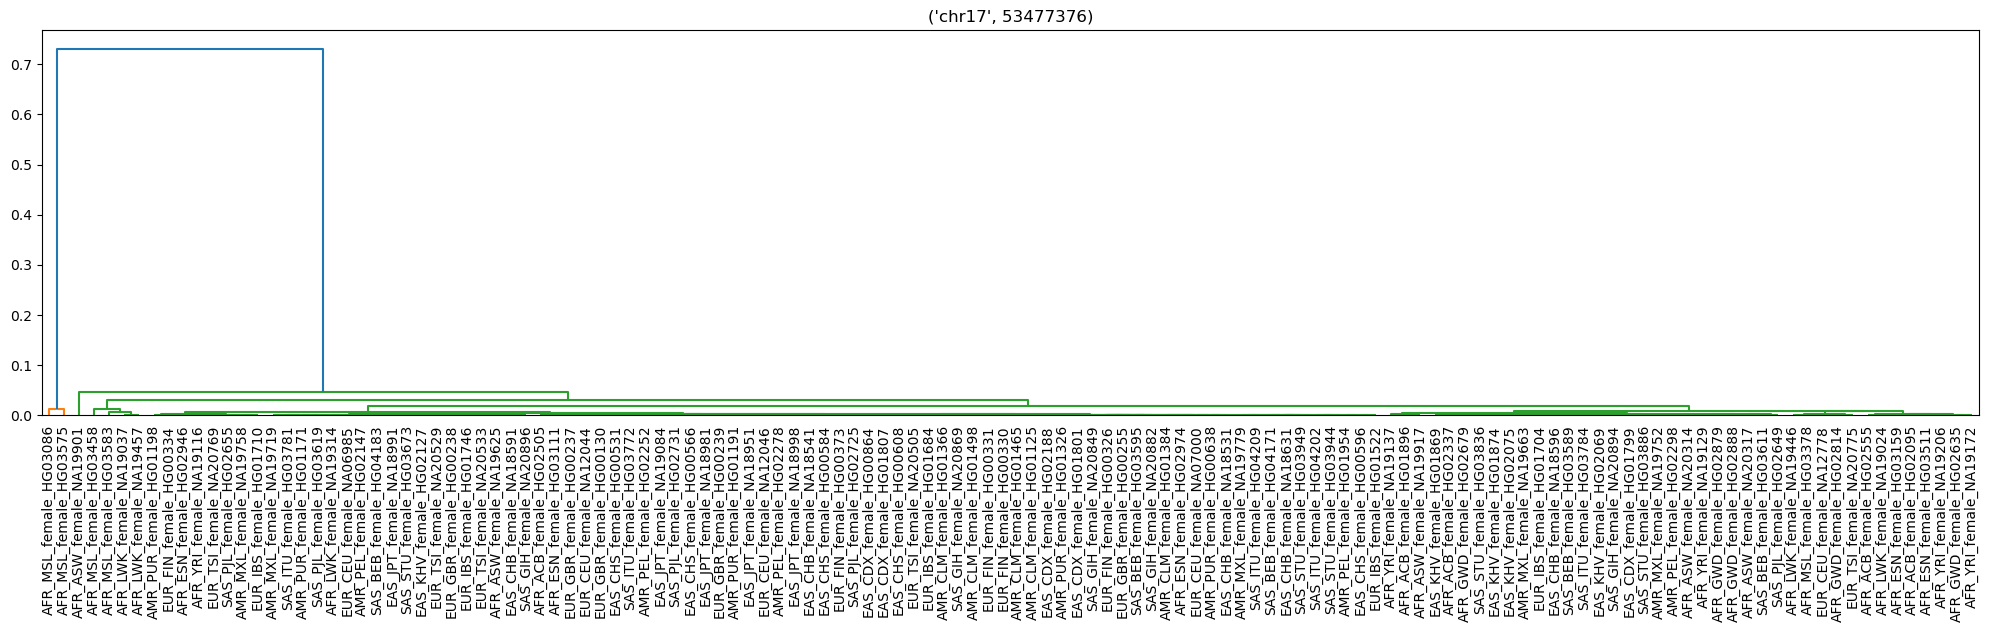

In [14]:
for i in dataframe[dataframe.coord_1 > 0.5].index:
    get_window_dendrogram(i)
    plt.show()

In [15]:
dataframe[dataframe.coord_1 > 0.3][dataframe.coord_1 <= 0.5]

/scratch/egilbertson/ipykernel_19897/1575417856.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataframe[dataframe.coord_1 > 0.3][dataframe.coord_1 <= 0.5]


AFR_ACB_female_HG01896 AFR_ACB_female_HG02095  \
(chr1, 104333312)                      C1                     C1   
(chr2, 35127296)                       C2                     C2   
(chr2, 51380224)                       C2                     C2   
(chr2, 81264640)                       C1                     C1   
(chr2, 81788928)                       C1                     C1   
(chr2, 116391936)                      C1                     C1   
(chr3, 6815744)                        C1                     C1   
(chr3, 28311552)                       C0                     C1   
(chr3, 175112192)                      C1                     C1   
(chr4, 166199296)                      C2                     C2   
(chr4, 166723584)                      C2                     C2   
(chr4, 178782208)                      C2                     C2   
(chr5, 27787264)                       C1                     C1   
(chr6, 60293120)                       C1                     C1   
(chr7, 3145728)                        C1                     C1   
(chr7, 40370176)                       C1                     C1   
(chr7, 51380224)                       C2                     C2   
(chr7, 51904512)                       C1                     C2   
(chr8, 2621440)                        C2                     C2   
(chr8, 83361792)                       C1                     C1   
(chr8, 114294784)                      C1                     C1   
(chr8, 114819072)                      C1                     C1   
(chr10, 1572864)                       C2                     C1   
(chr10, 37224448)                      C2                     C2   
(chr10, 66060288)                      C1                     C1   
(chr11, 90701824)                      C2                     C2   
(chr12, 23592960)                      C1                     C1   
(chr13, 103809024)                     C1                     C1   
(chr14, 46137344)                      C1                     C1   
(chr18, 52953088)                      C2                     C2   
(chr19, 19922944)                      C2                     C2   
(chr21, 16252928)                      C1                     C1   
(chr21, 21495808)                      C2                     C2   
(chr22, 47185920)                      C1                     C1   
(chr22, 48234496)                      C2                     C2   

                   AFR_ACB_female_HG02337 AFR_ACB_female_HG02505  \
(chr1, 104333312)                      C1                     C1   
(chr2, 35127296)                       C1                     C2   
(chr2, 51380224)                       C1                     C2   
(chr2, 81264640)                       C1                     C1   
(chr2, 81788928)                       C1                     C1   
(chr2, 116391936)                      C1                     C1   
(chr3, 6815744)                        C1                     C1   
(chr3, 28311552)                       C1                     C1   
(chr3, 175112192)                      C1                     C1   
(chr4, 166199296)                      C2                     C2   
(chr4, 166723584)                      C2                     C2   
(chr4, 178782208)                      C2                     C2   
(chr5, 27787264)                       C1                     C1   
(chr6, 60293120)                       C1                     C1   
(chr7, 3145728)                        C1                     C1   
(chr7, 40370176)                       C1                     C1   
(chr7, 51380224)                       C2                     C2   
(chr7, 51904512)                       C1                     C2   
(chr8, 2621440)                        C2                     C2   
(chr8, 83361792)                       C1                     C1   
(chr8, 114294784)                      C1                     C1   
(chr8, 114819072)                      C1                     C1   
(chr10

/scratch/egilbertson/ipykernel_19897/731495627.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in dataframe[dataframe.coord_1 > 0.4][dataframe.coord_1 <= 0.5].index:


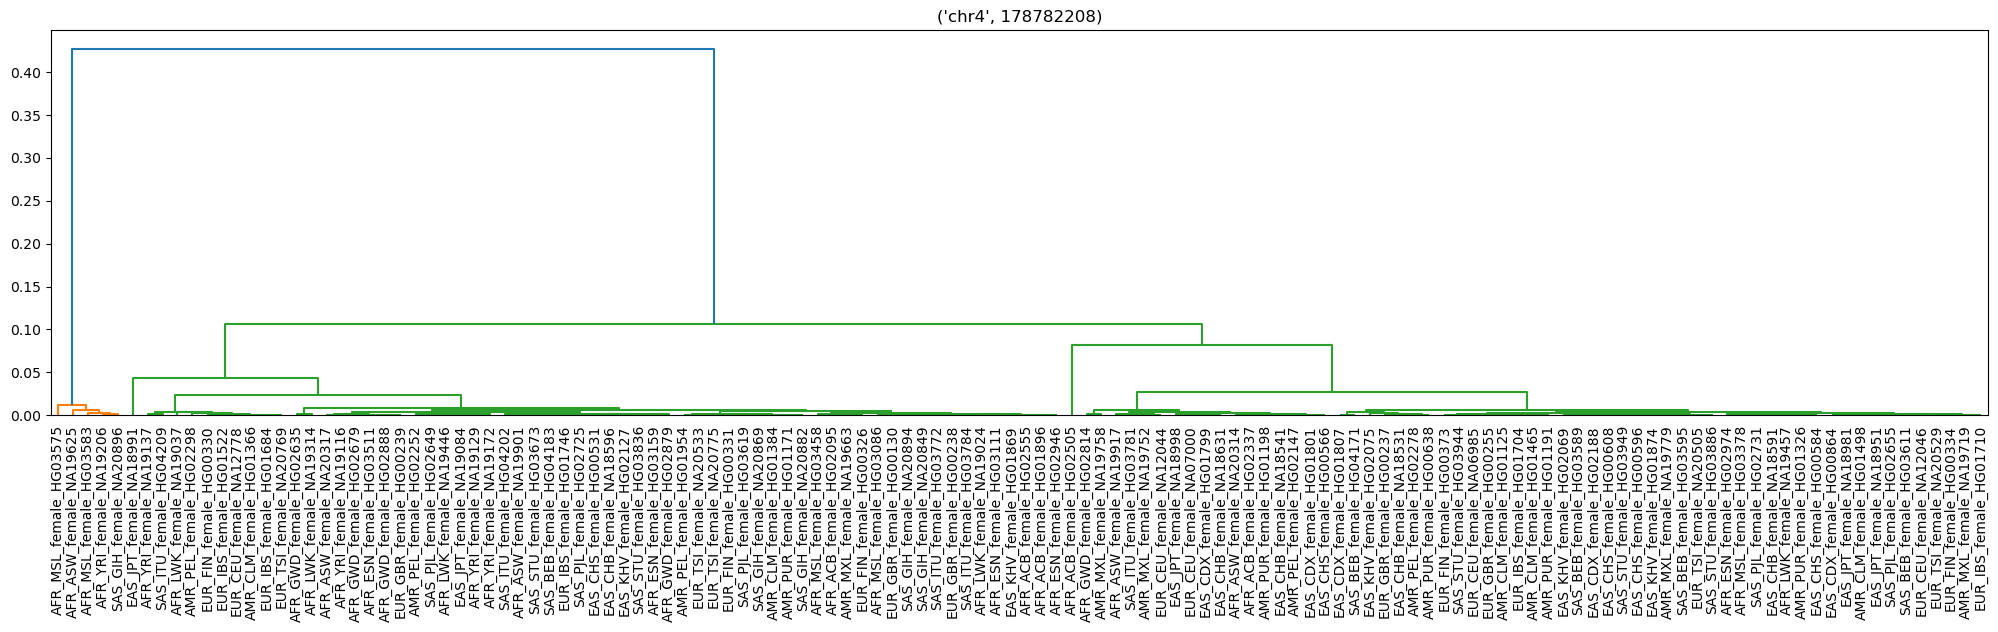

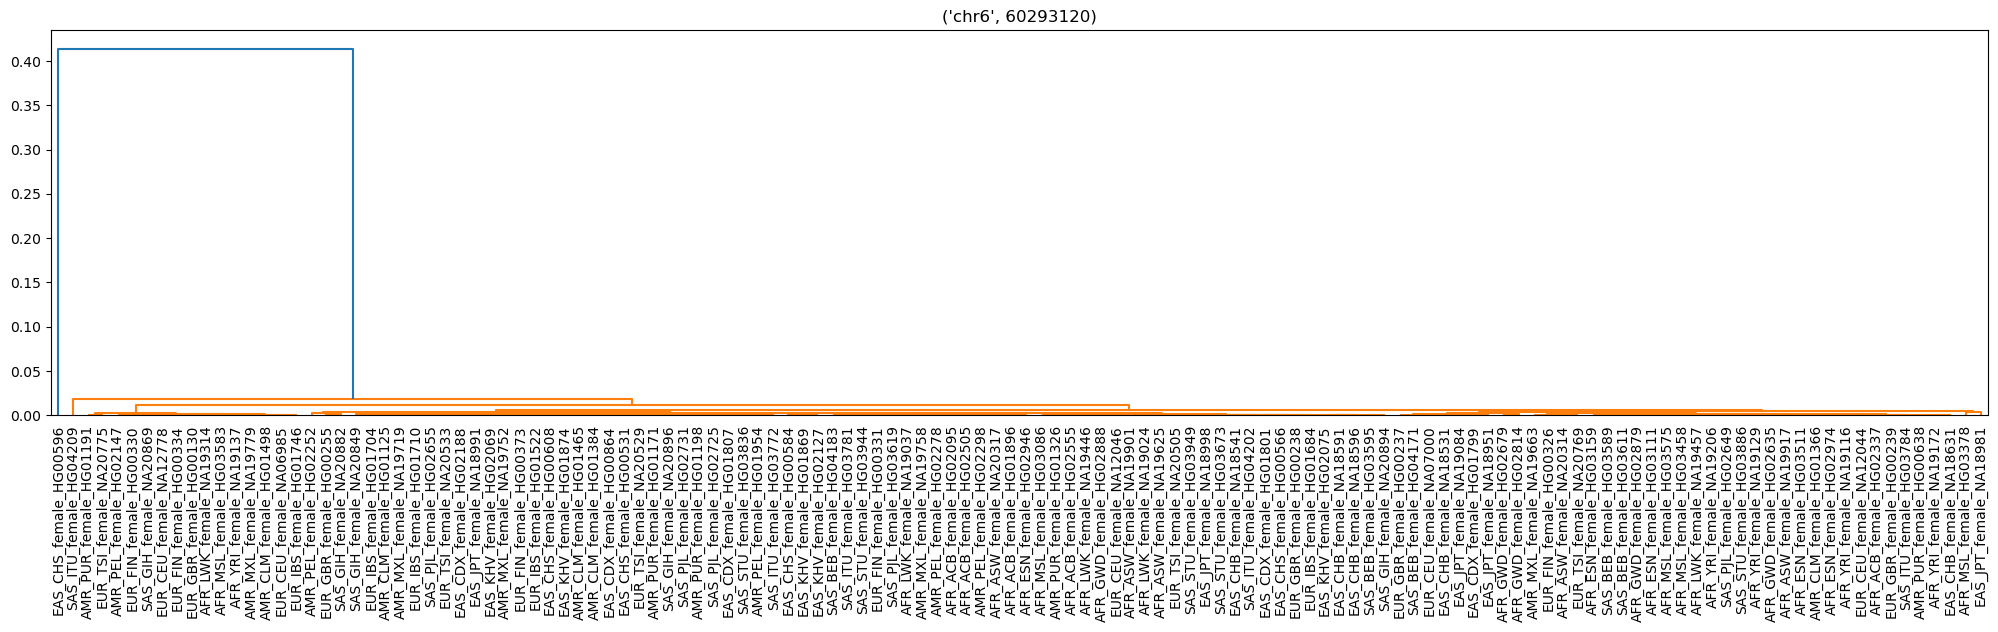

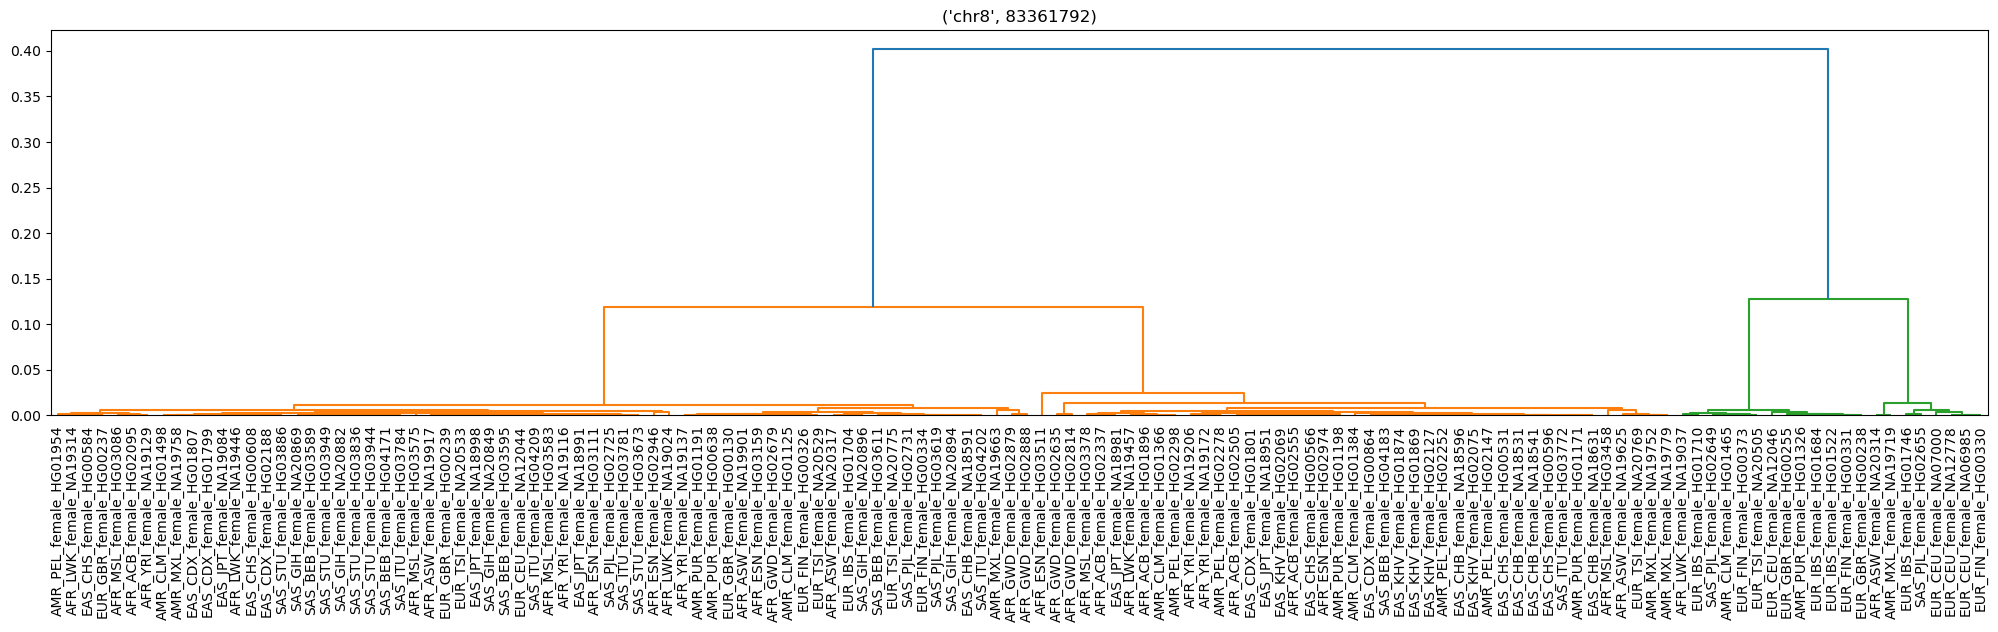

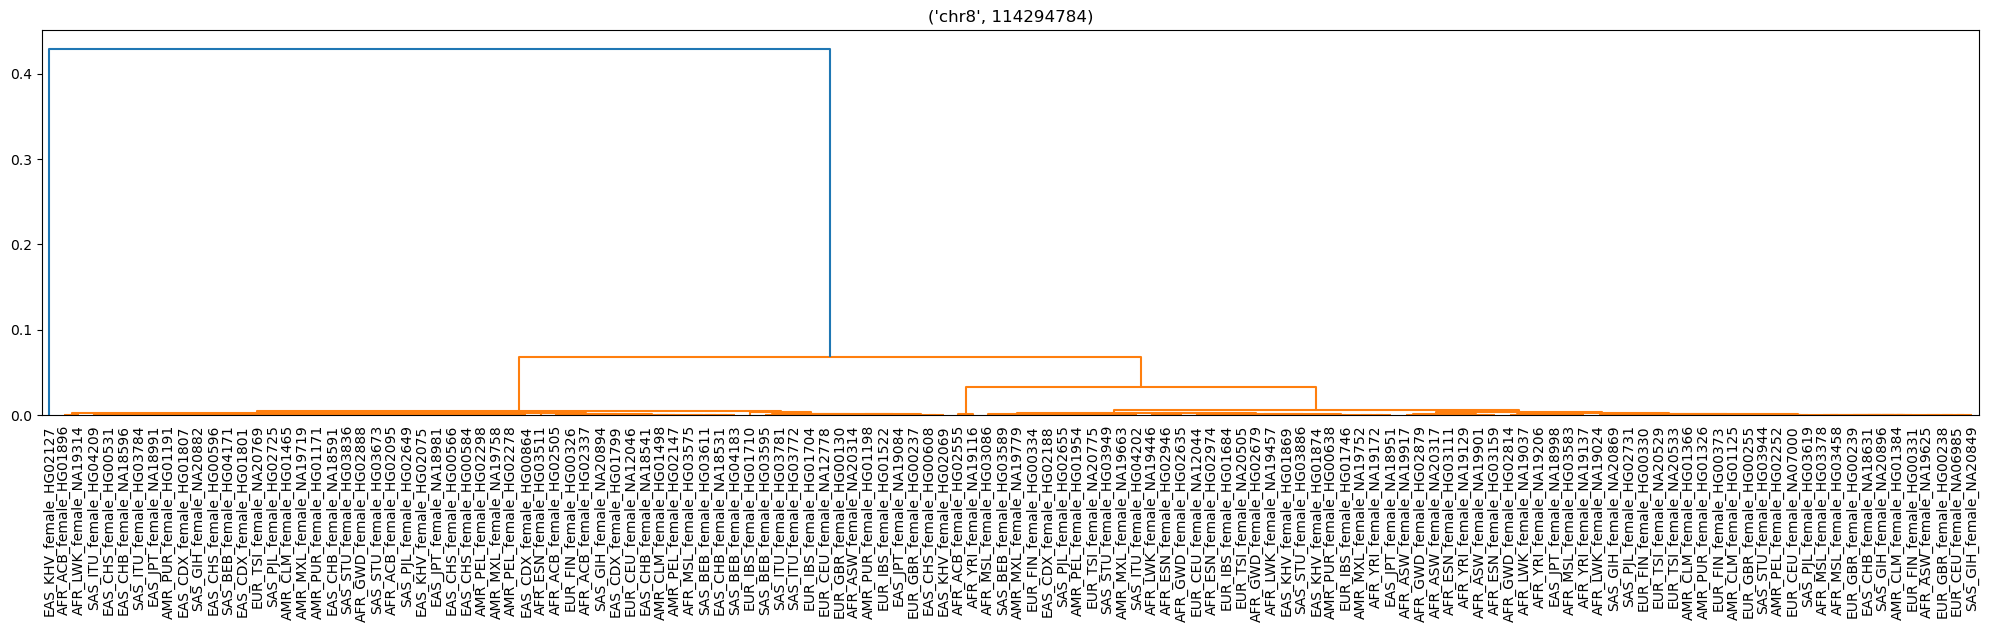

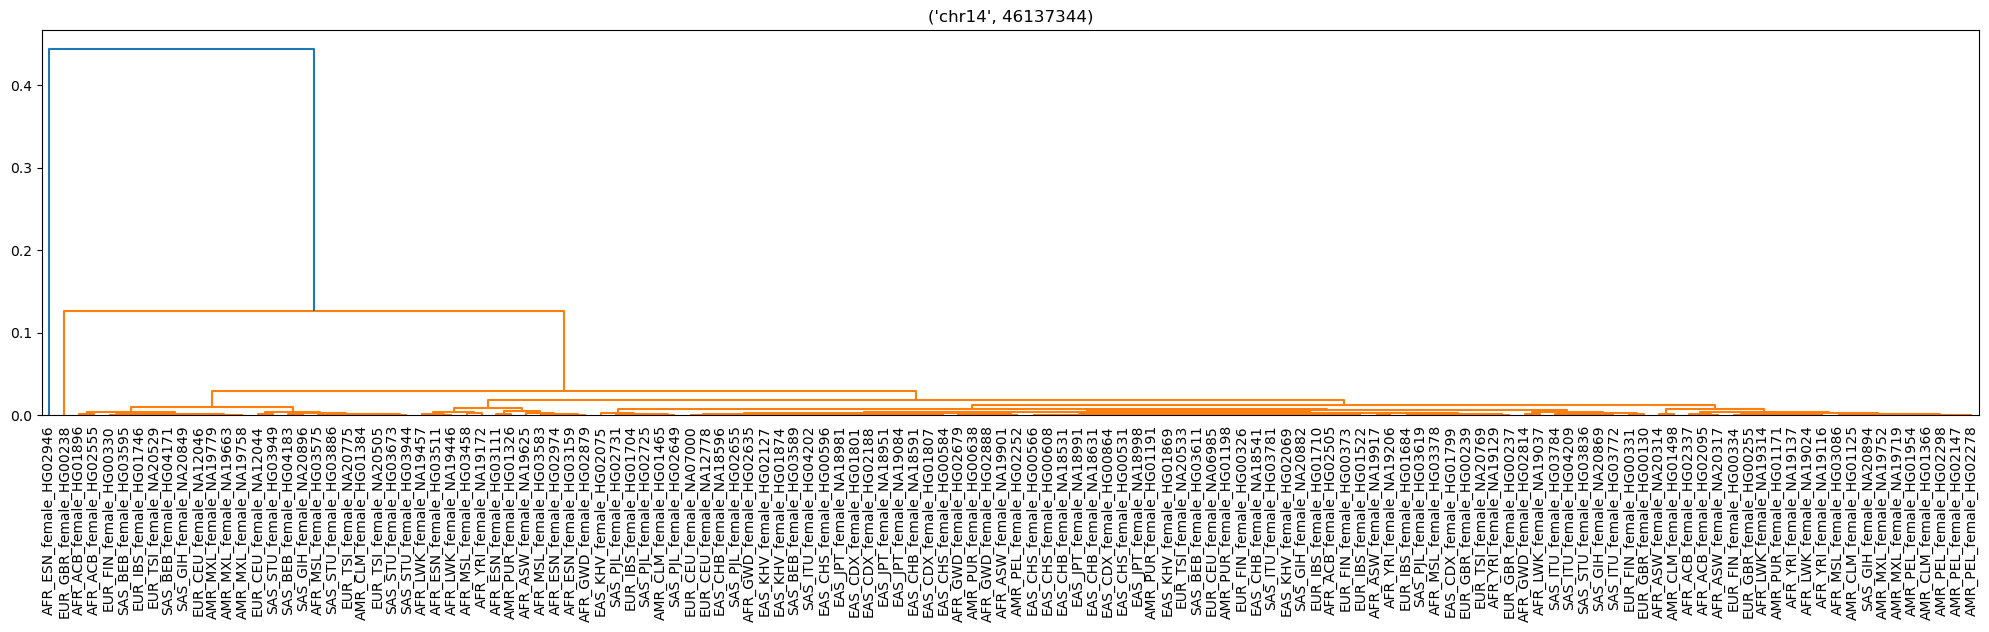

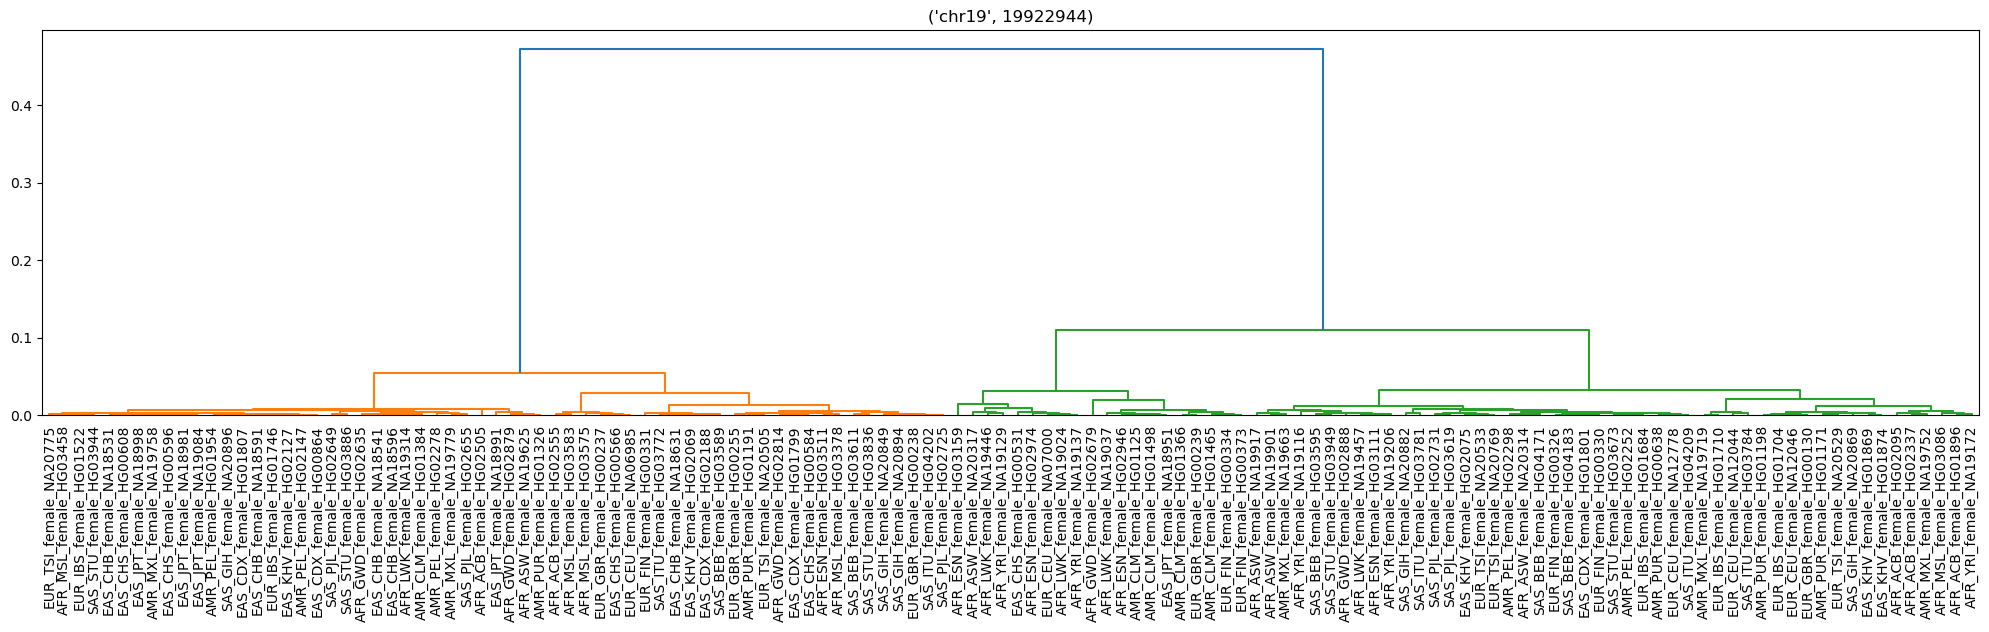

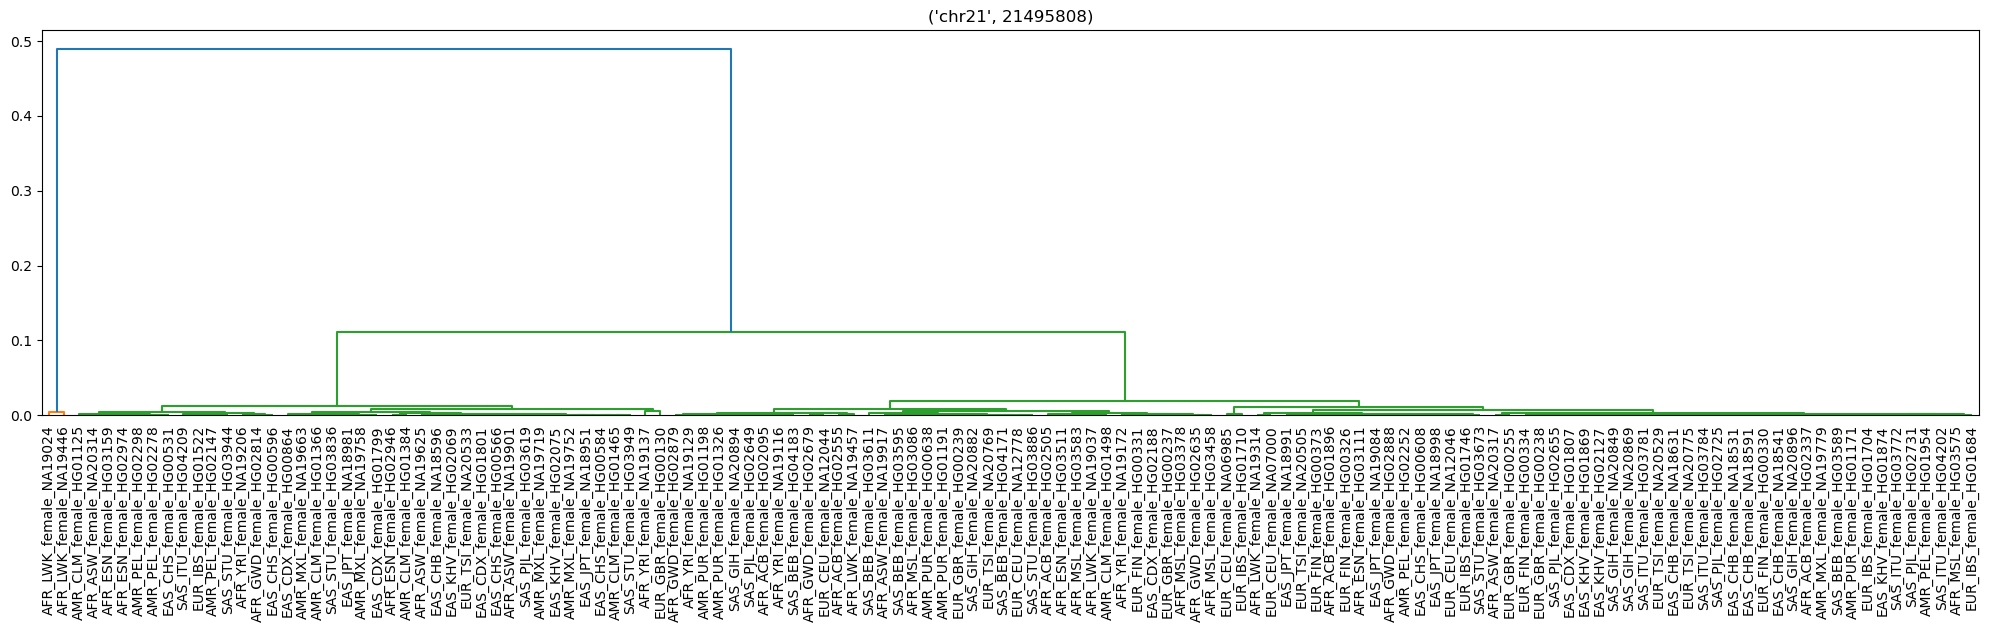

In [16]:
for i in dataframe[dataframe.coord_1 > 0.4][dataframe.coord_1 <= 0.5].index:
    get_window_dendrogram(i)
    plt.show()

(array([2.665e+03, 9.640e+02, 4.430e+02, 2.320e+02, 1.600e+02, 9.100e+01,
        7.000e+01, 3.900e+01, 3.400e+01, 3.600e+01, 1.500e+01, 1.600e+01,
        9.000e+00, 1.400e+01, 1.100e+01, 6.000e+00, 6.000e+00, 3.000e+00,
        4.000e+00, 6.000e+00, 9.000e+00, 9.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.01462396, 0.02924792, 0.04387189, 0.05849585,
        0.07311981, 0.08774377, 0.10236774, 0.1169917 , 0.13161566,
        0.14623962, 0.16086358, 0.17548755, 0.19011151, 0.20473547,
        0.21935943, 0.2339834 , 0.24860736, 0.26323132, 0.27785528,
        0.29247924, 0.30710321, 0.32172717, 0.33635113, 0.35097509,
        0.36559906, 0.38022302, 0.39

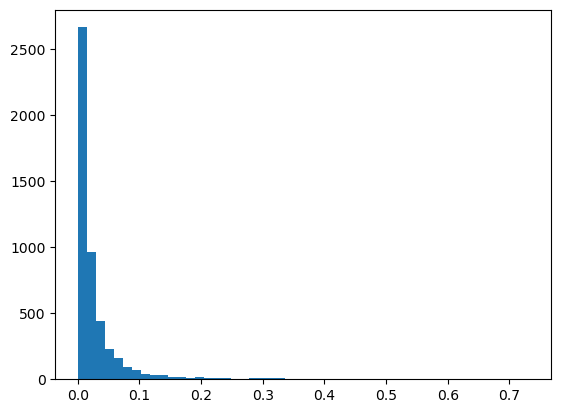

In [17]:
plt.hist(dataframe['coord_1'], bins=50)

/scratch/egilbertson/ipykernel_19897/1326875249.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  for i in dataframe[dataframe.eq('C5').any(1)].index:


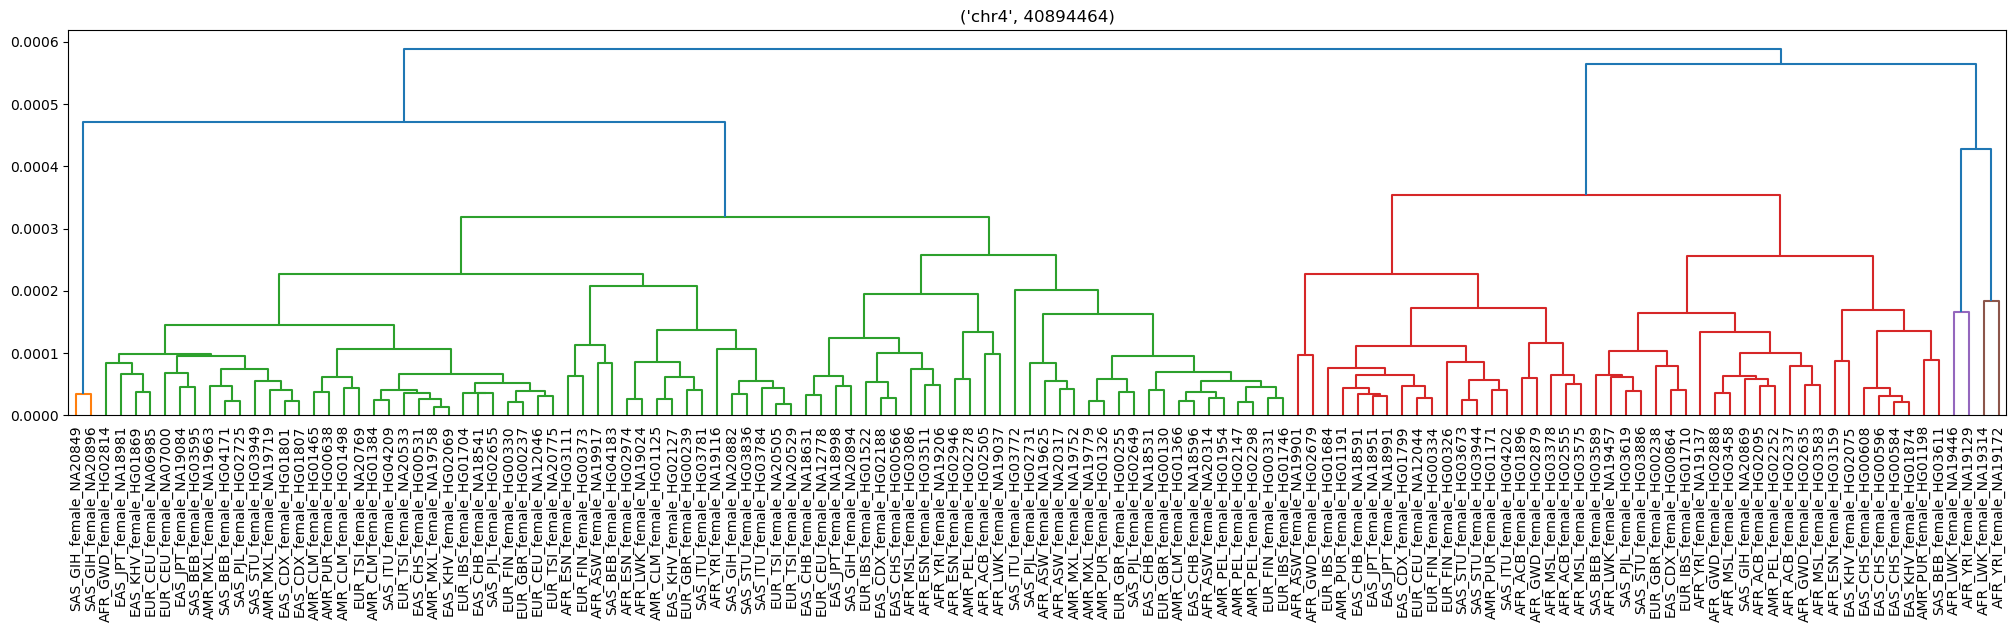

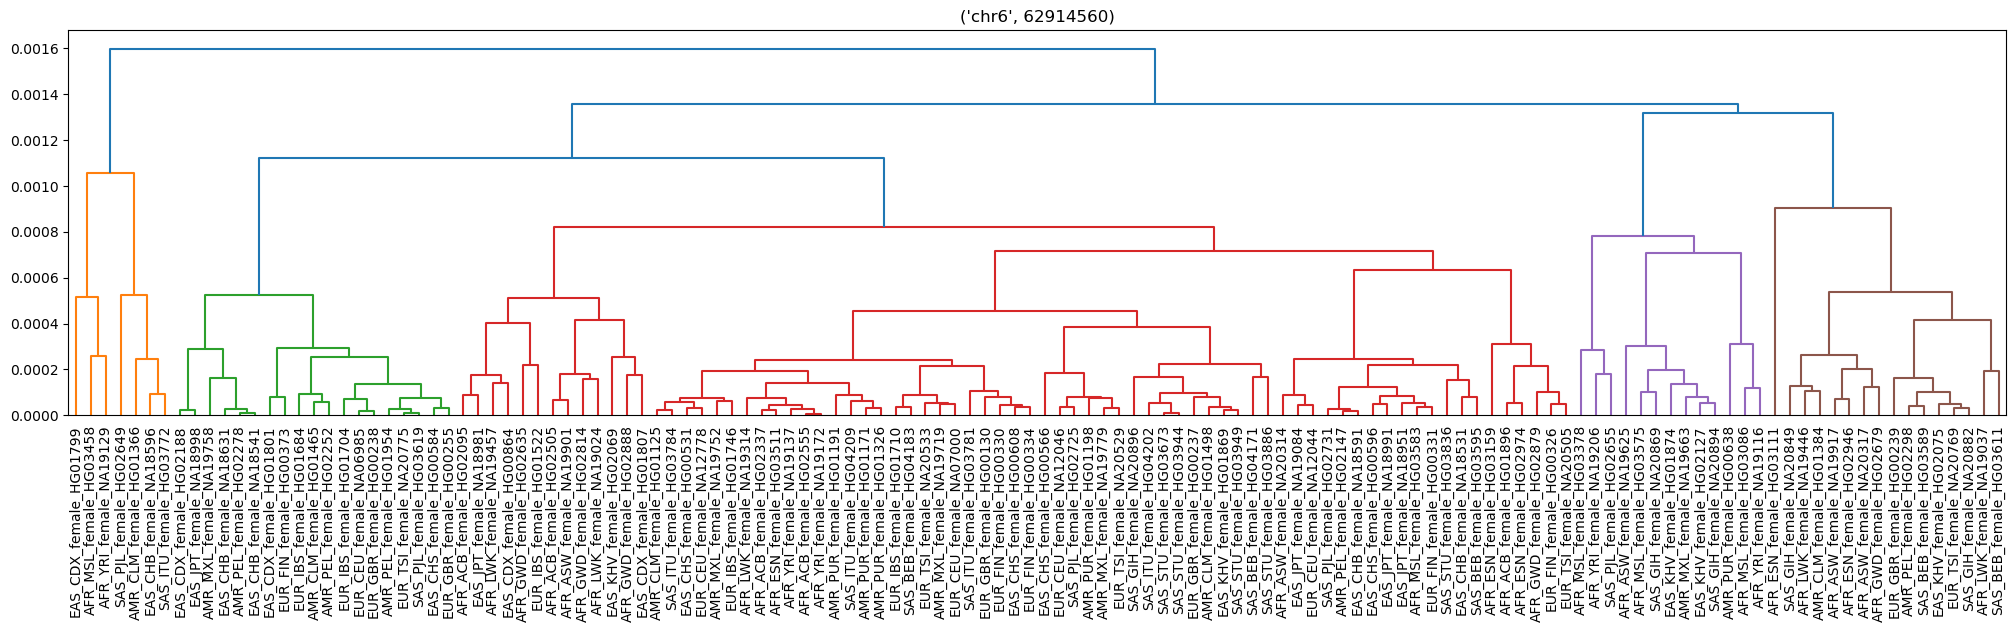

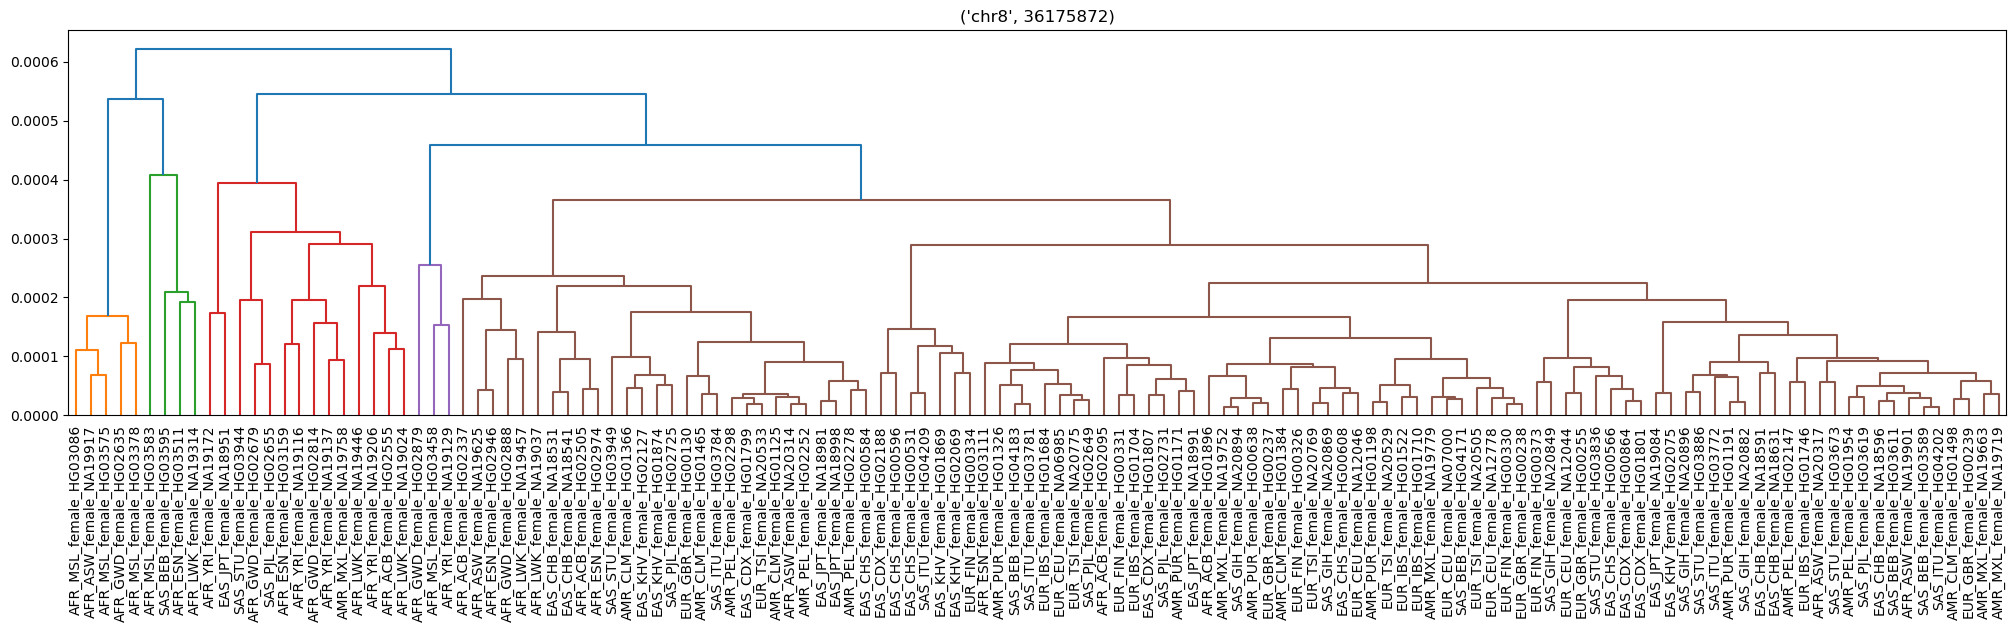

In [18]:
for i in dataframe[dataframe.eq('C5').any(1)].index:
    get_window_dendrogram(i)
    plt.show()

In [19]:
dataframe

AFR_ACB_female_HG01896 AFR_ACB_female_HG02095  \
(chr1, 1048576)                       C3                     C2   
(chr1, 1572864)                       C2                     C1   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C1                     C2   
(chr1, 4194304)                       C1                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C3                     C1   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C1                     C1   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C3                     C2   

                  AFR_ACB_female_HG02337 AFR_ACB_female_HG02505  \
(chr1, 1048576)                       C1                     C3   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C2   
(chr1, 3670016)                       C1                     C2   
(chr1, 4194304)                       C1                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C3                     C3   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C3                     C3   

                  AFR_ACB_female_HG02555 AFR_ASW_female_NA19625  \
(chr1, 1048576)                       C1                     C3   
(chr1, 1572864)                       C1                     C2   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C2                     C2   
(chr1, 4194304)                       C2                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C3                     C3   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C1   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C3                     C1   

                  AFR_ASW_female_NA19901 AFR_ASW_female_NA19917  \
(chr1, 1048576)                       C2                     C3   
(chr1, 1572864)                       C1                     C2   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C0                     C1   
(chr1, 4194304)                       C2                     C1   
...                                  ...                    ...   
(chr22, 46661632)                     C3                     C3   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C1                     C1   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C2                     C2   

                  AFR_ASW_female_NA20314 AFR_ASW_female_NA20317  ...  \
(chr1, 1048576)                       C2                     C1  ...   
(chr1, 1572864)                       C1                     C1  ...   
(chr1, 3145728)                       C3                     C3  ...   
(chr1, 3670016)                       C1                     C2  ...   
(chr1, 4194304)                       C1                     C2  ...   
...                                  ...                    ...  ...   
(chr22, 46661632)                     C3                     C1  ...   
(chr22, 47185920)                     C1                     C1  ...   
(chr22, 47710208)                     C1                     C1  ...   
(chr22, 48234496)                     C2                     C2  ...   
(chr22

In [20]:
w = dataframe.index[0]
counts_df = dataframe.drop(columns=['coord_0','coord_1', 'coord_2','coord_3']).apply(lambda s: s.value_counts(), axis=1).fillna(0)     
counts_df['depth'] = dataframe['coord_1']


/scratch/egilbertson/ipykernel_19897/2170431393.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts_df[counts_df.C0!=0.0][counts_df.C4 != 0.0]
/scratch/egilbertson/ipykernel_19897/2170431393.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in counts_df[counts_df.C0!=0.0][counts_df.C4 != 0.0].index:


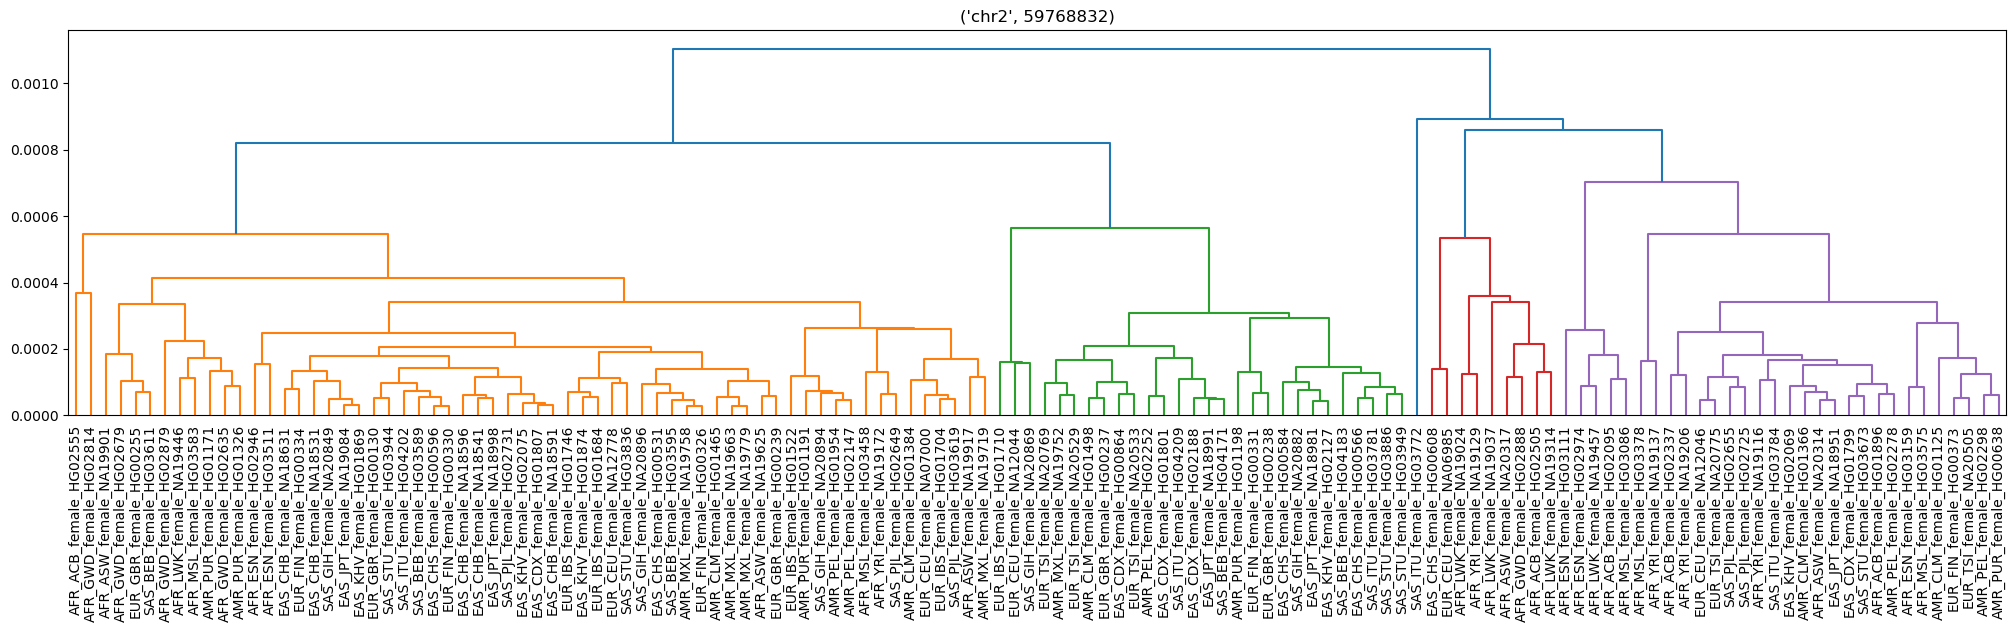

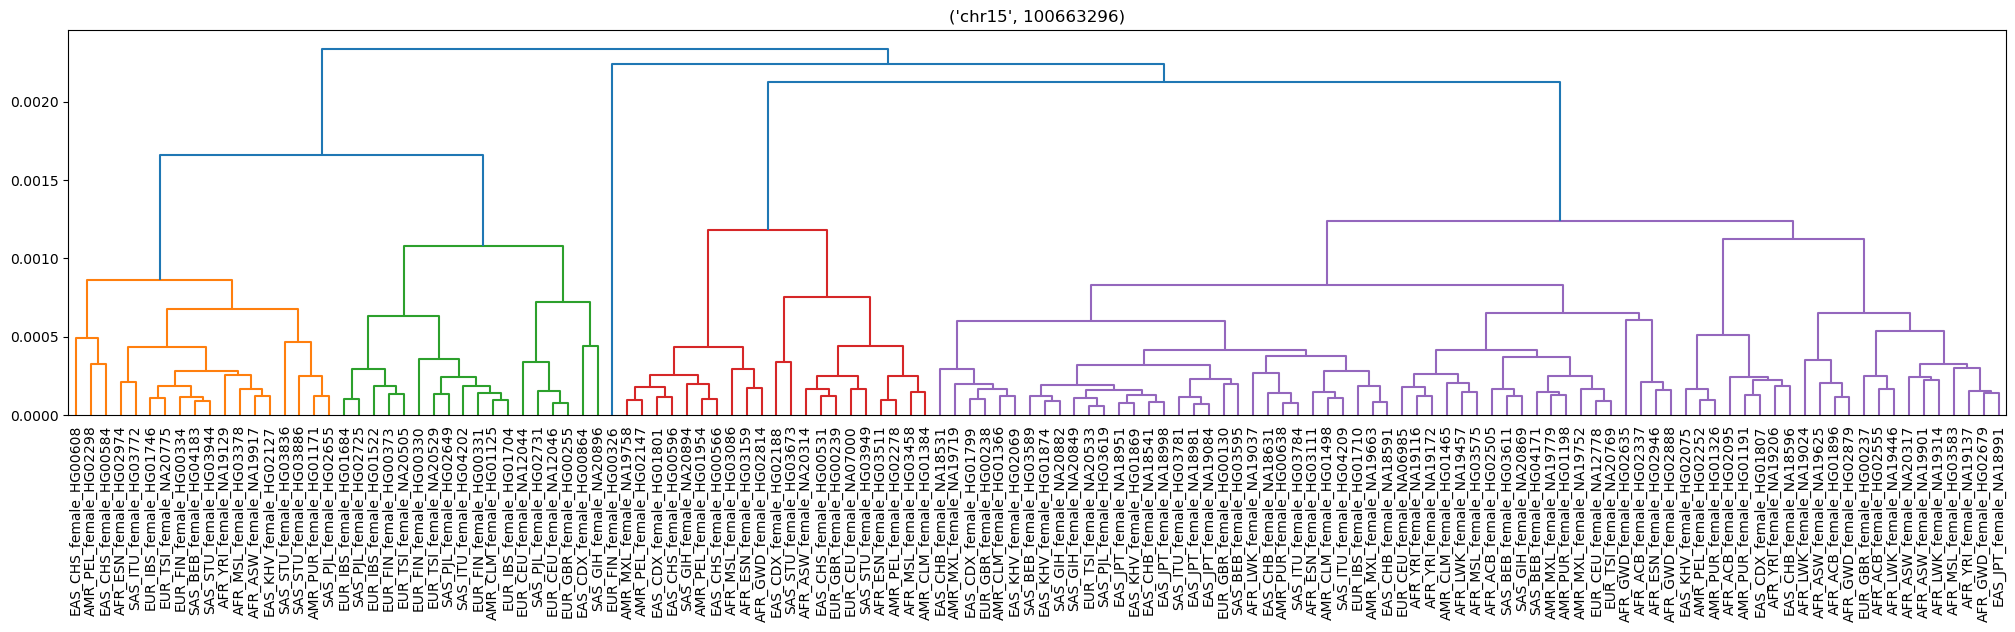

In [21]:
counts_df[counts_df.C0!=0.0][counts_df.C4 != 0.0]
for i in counts_df[counts_df.C0!=0.0][counts_df.C4 != 0.0].index:
    get_window_dendrogram(i)
    plt.show()

/scratch/egilbertson/ipykernel_19897/2847331605.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts_df[counts_df.C0!=0.0][counts_df.C4 == 0.0][counts_df.C3 != 0.0]
/scratch/egilbertson/ipykernel_19897/2847331605.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in counts_df[counts_df.C0!=0.0][counts_df.C4 == 0.0][counts_df.C3 != 0.0].index:


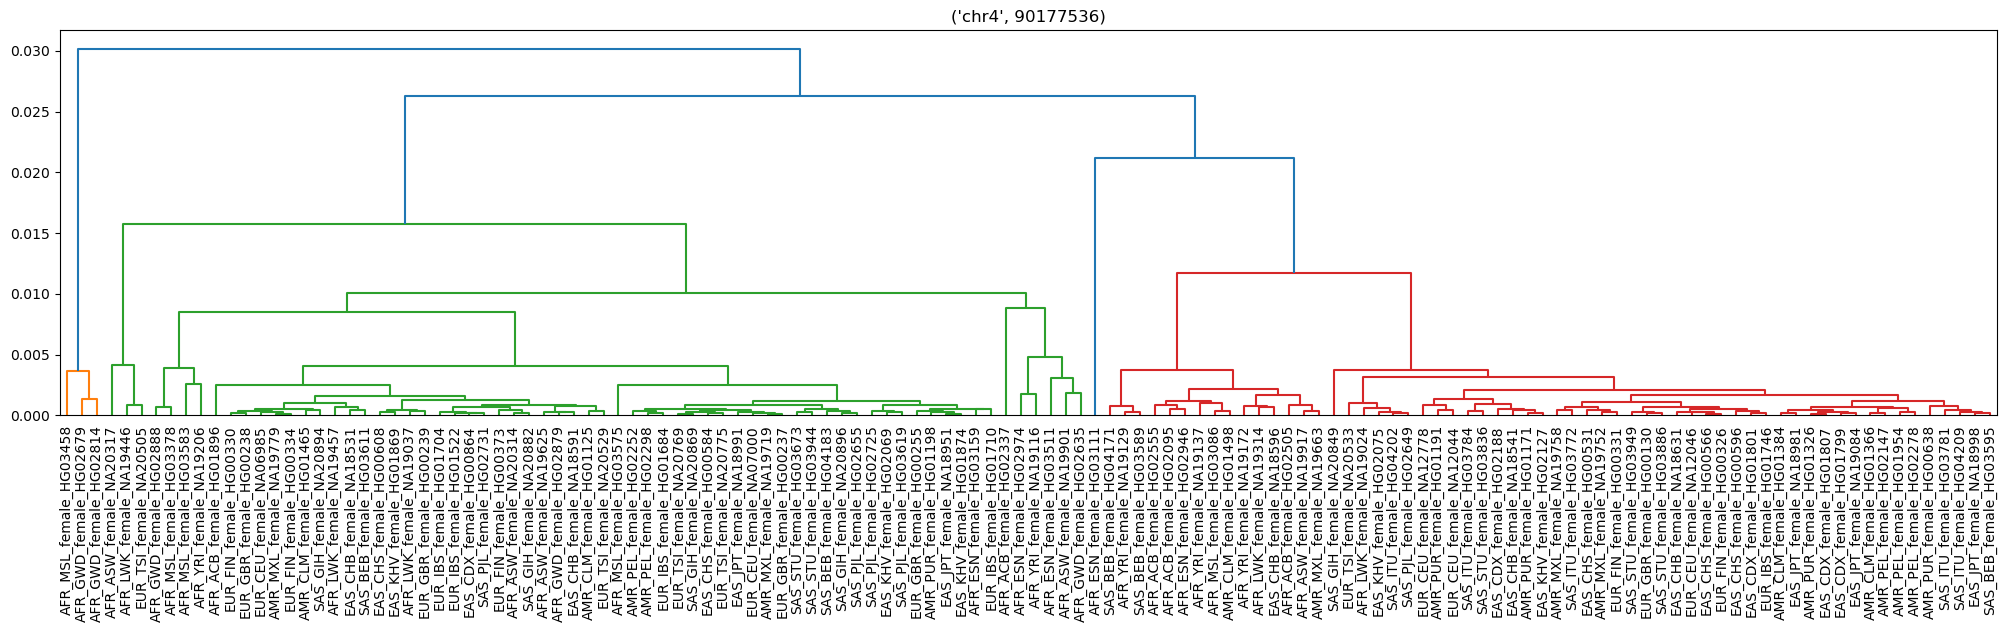

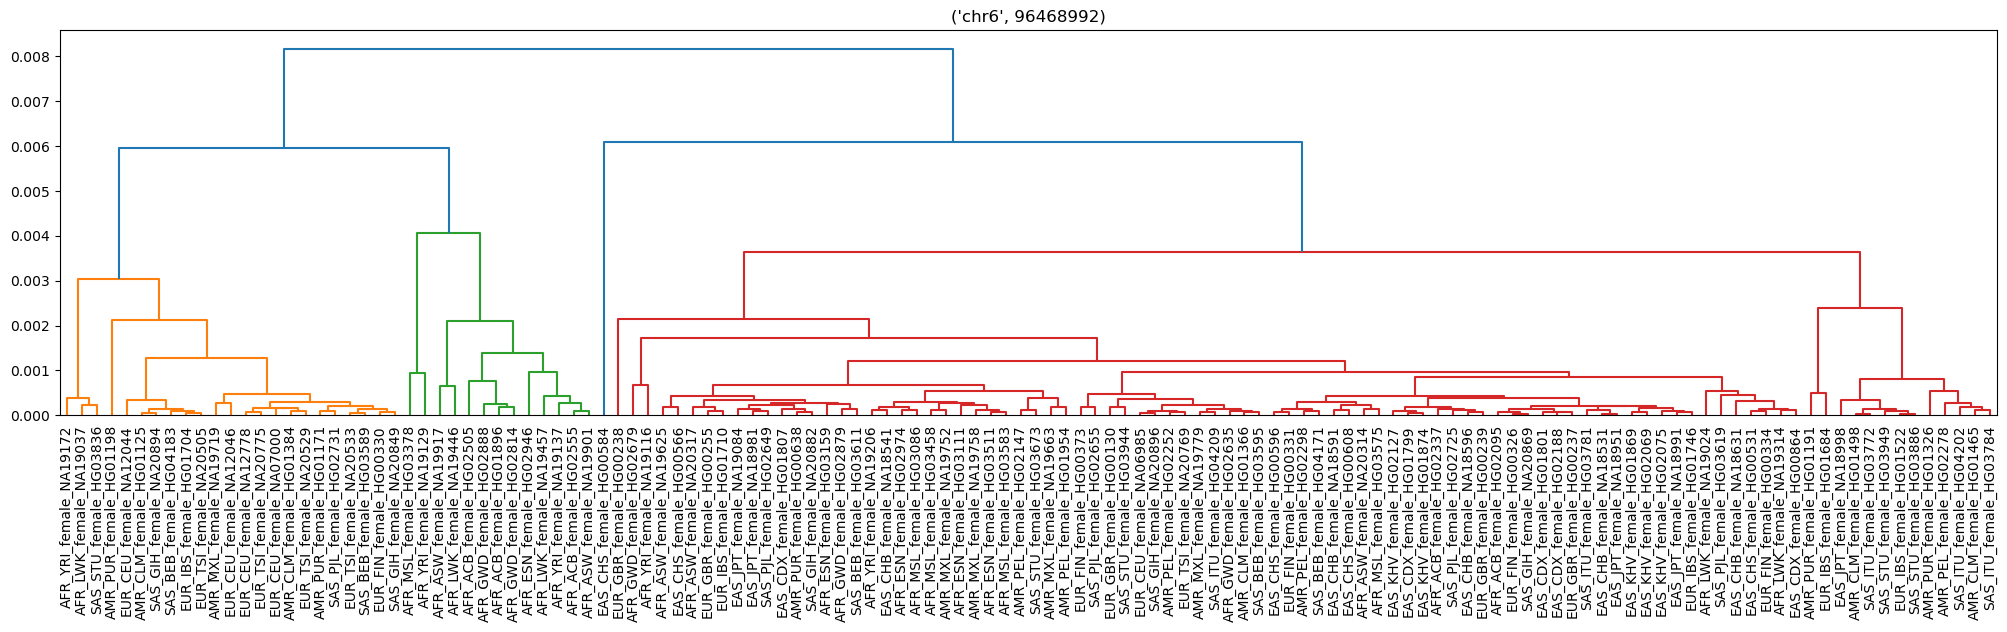

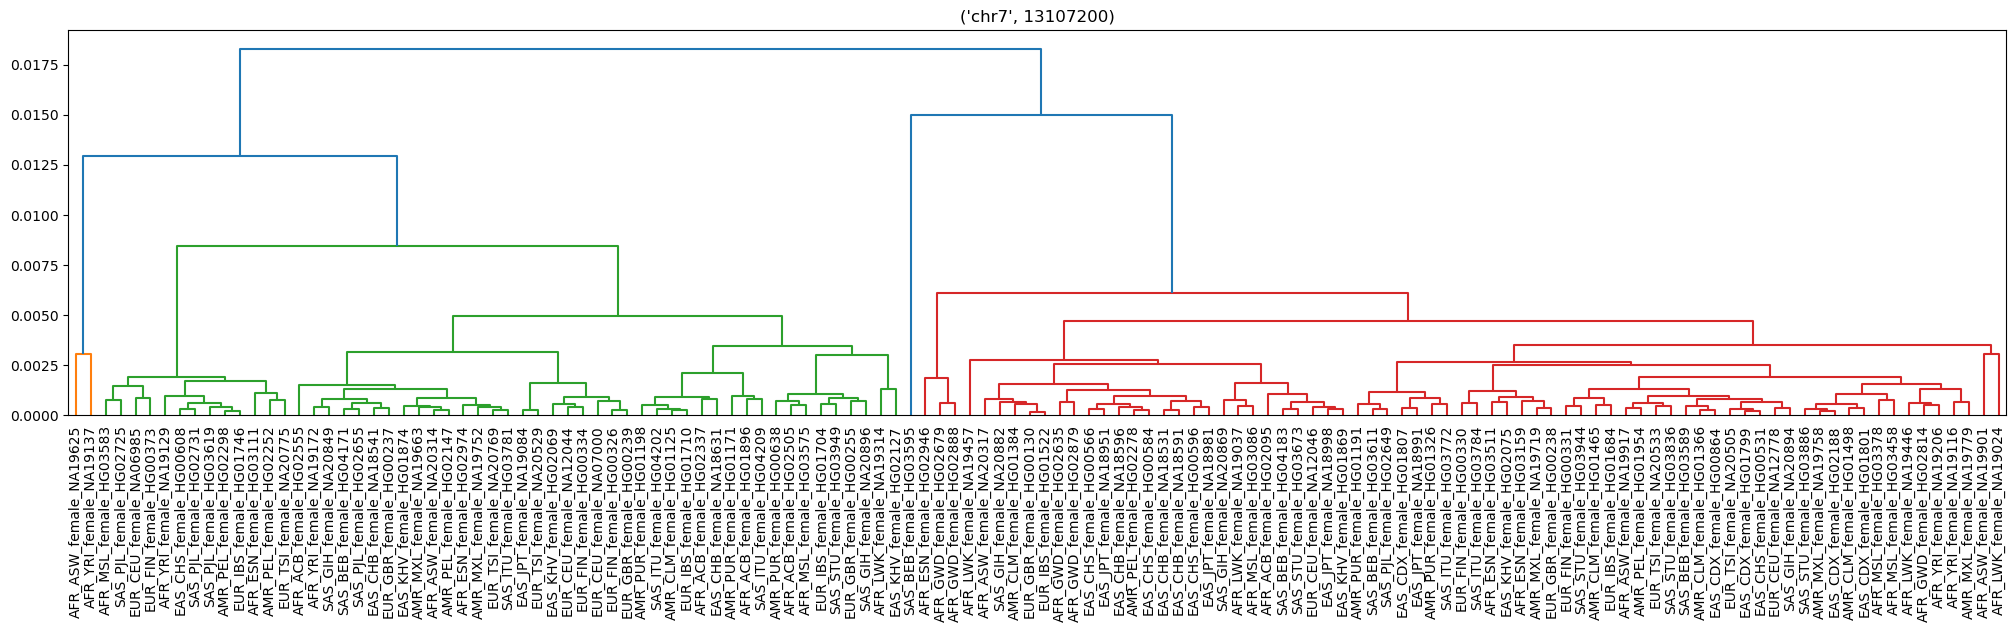

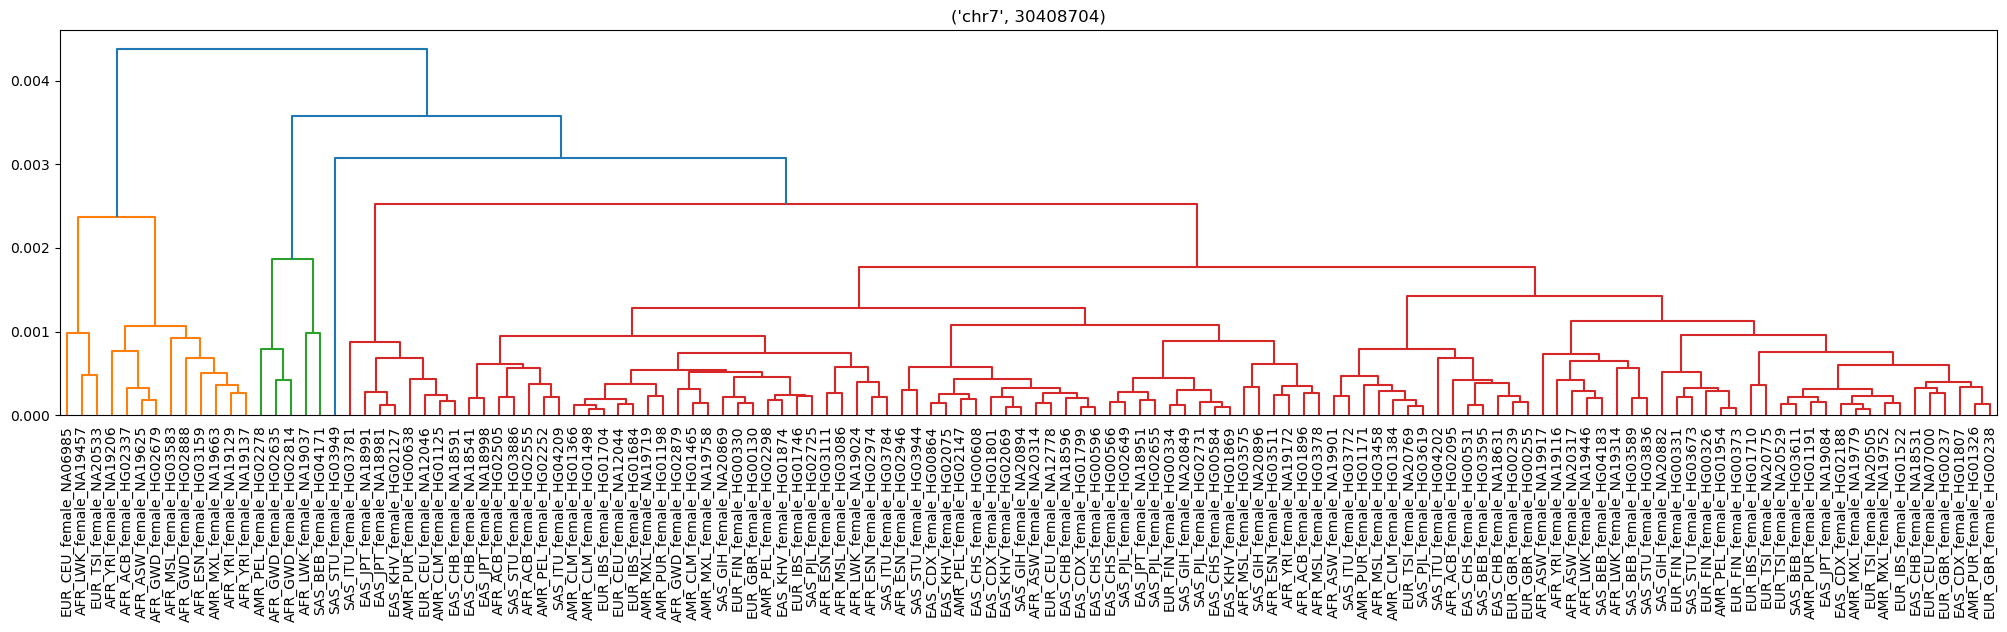

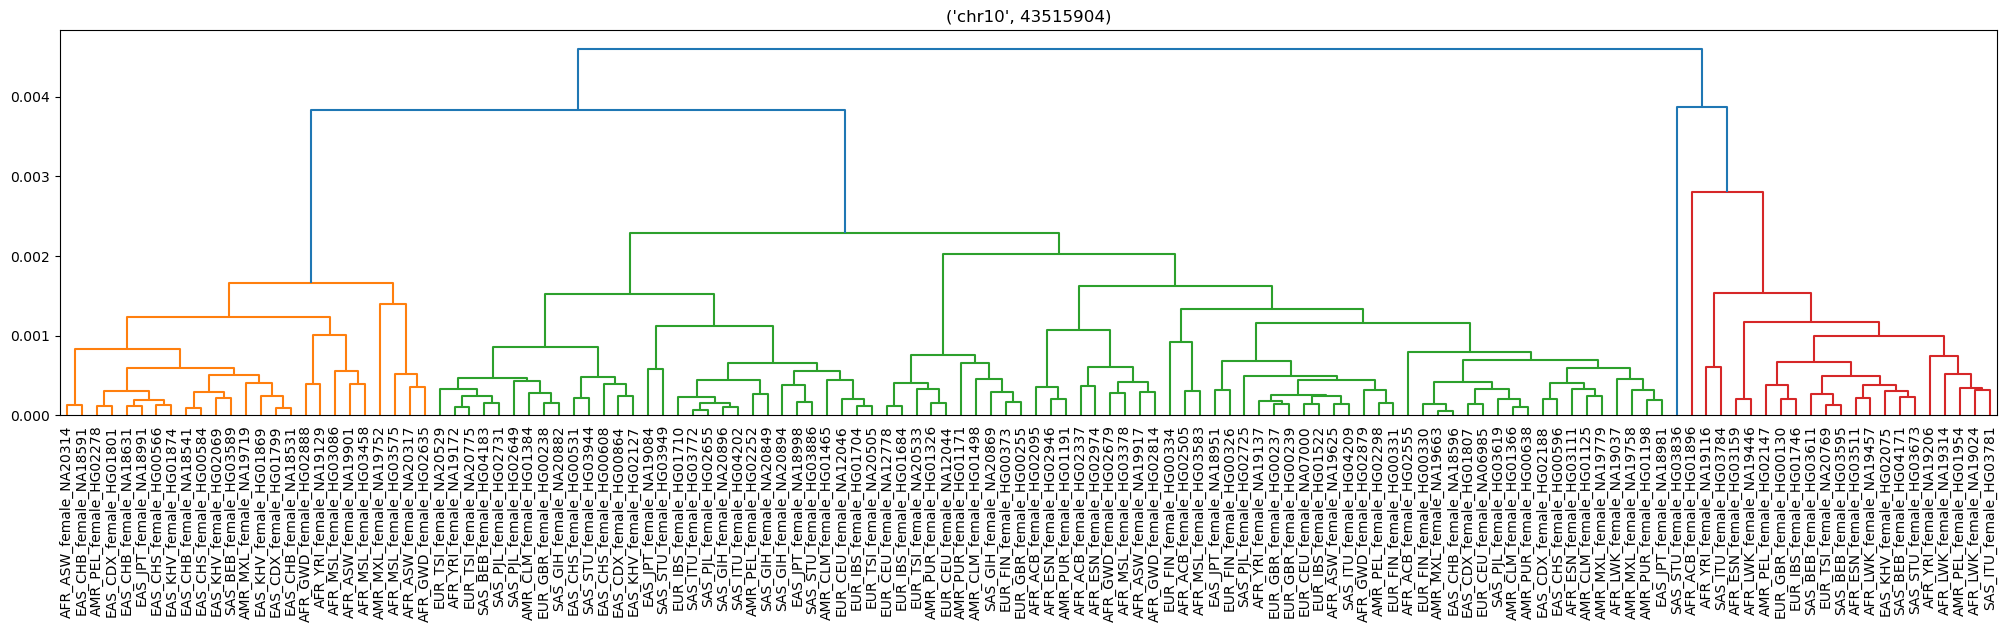

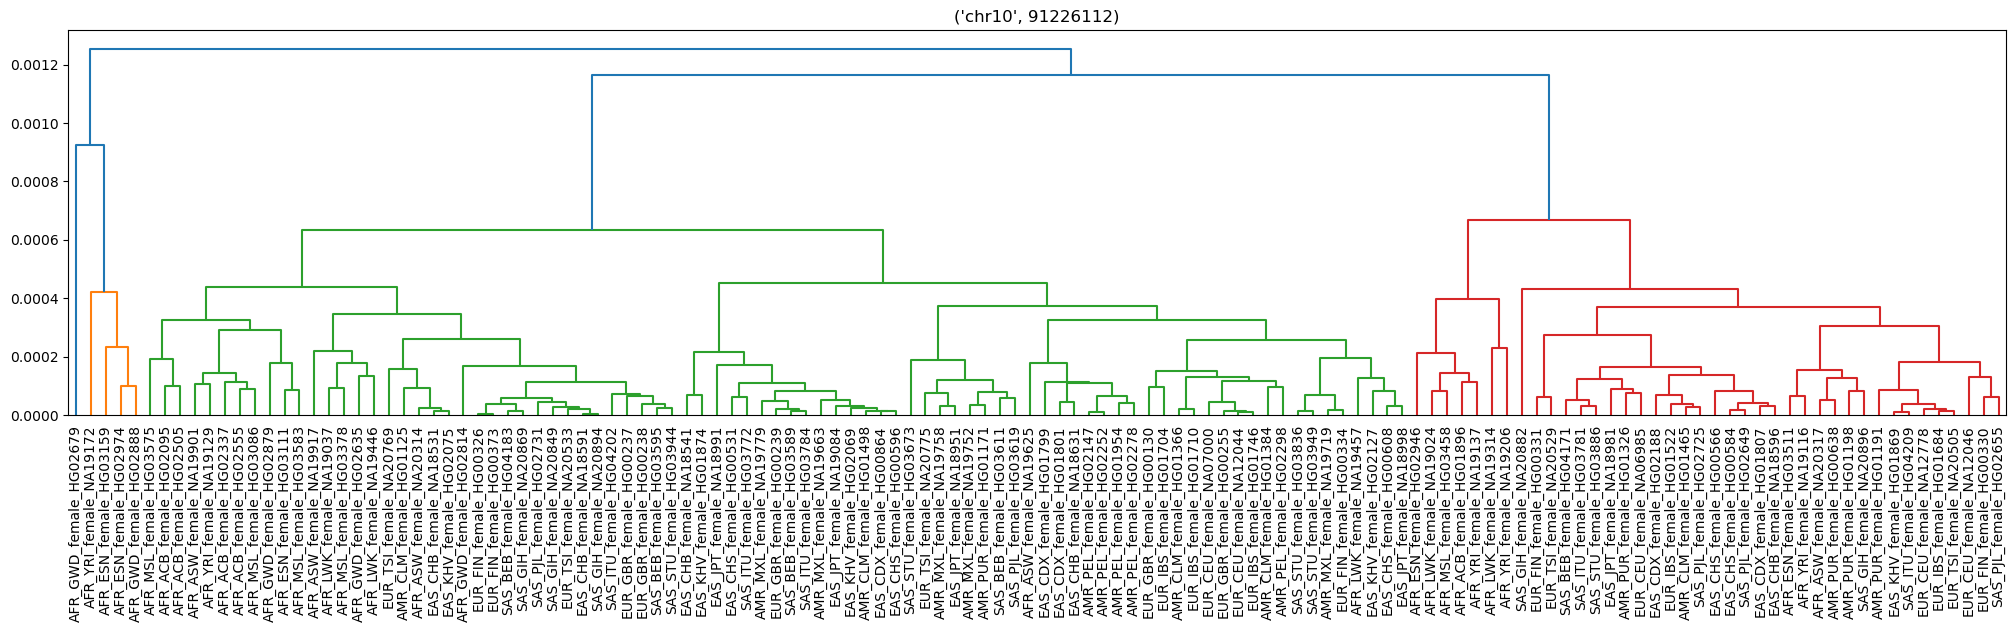

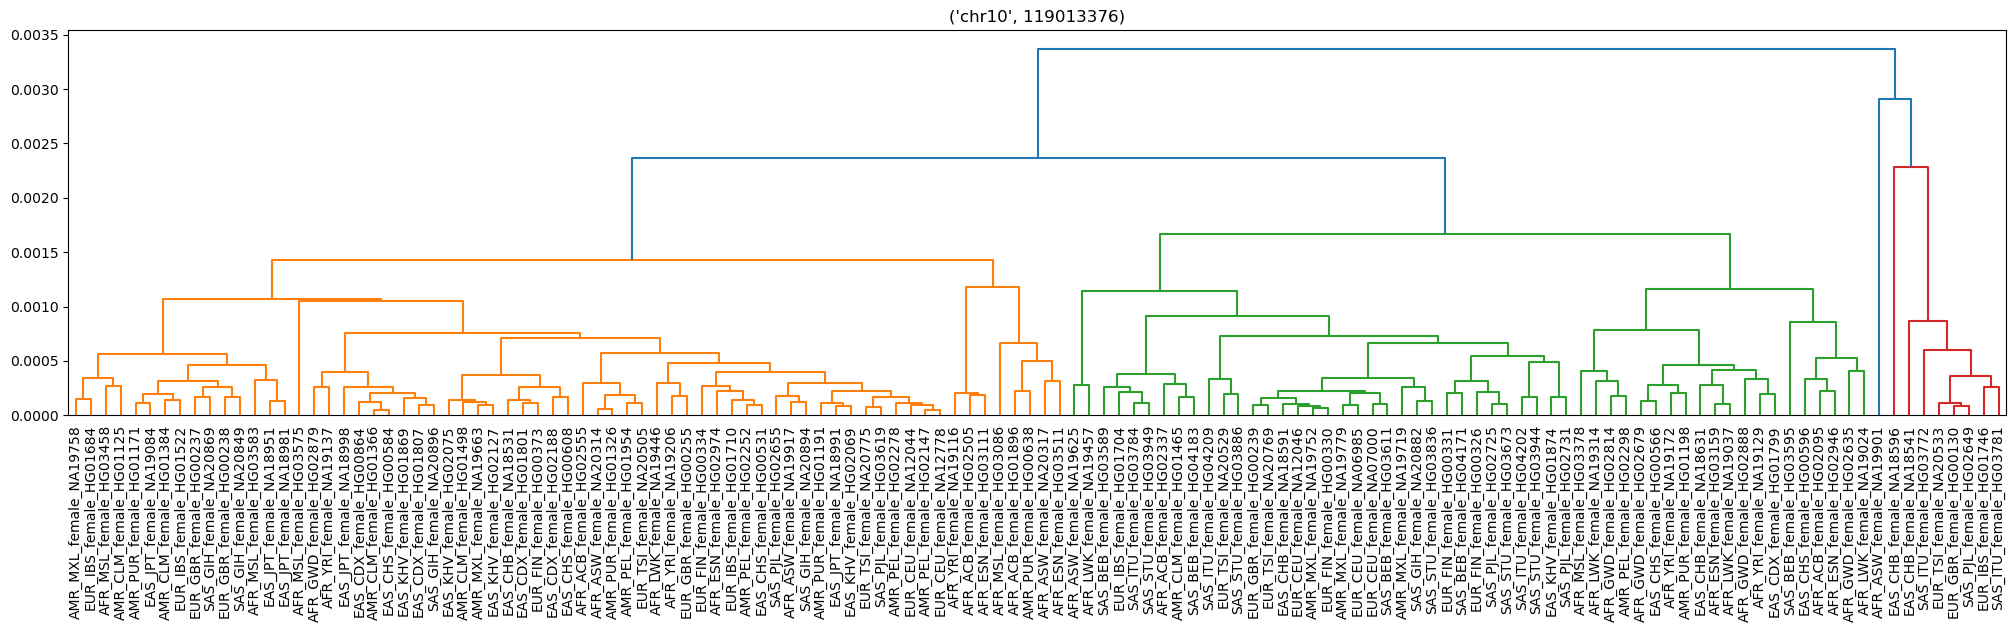

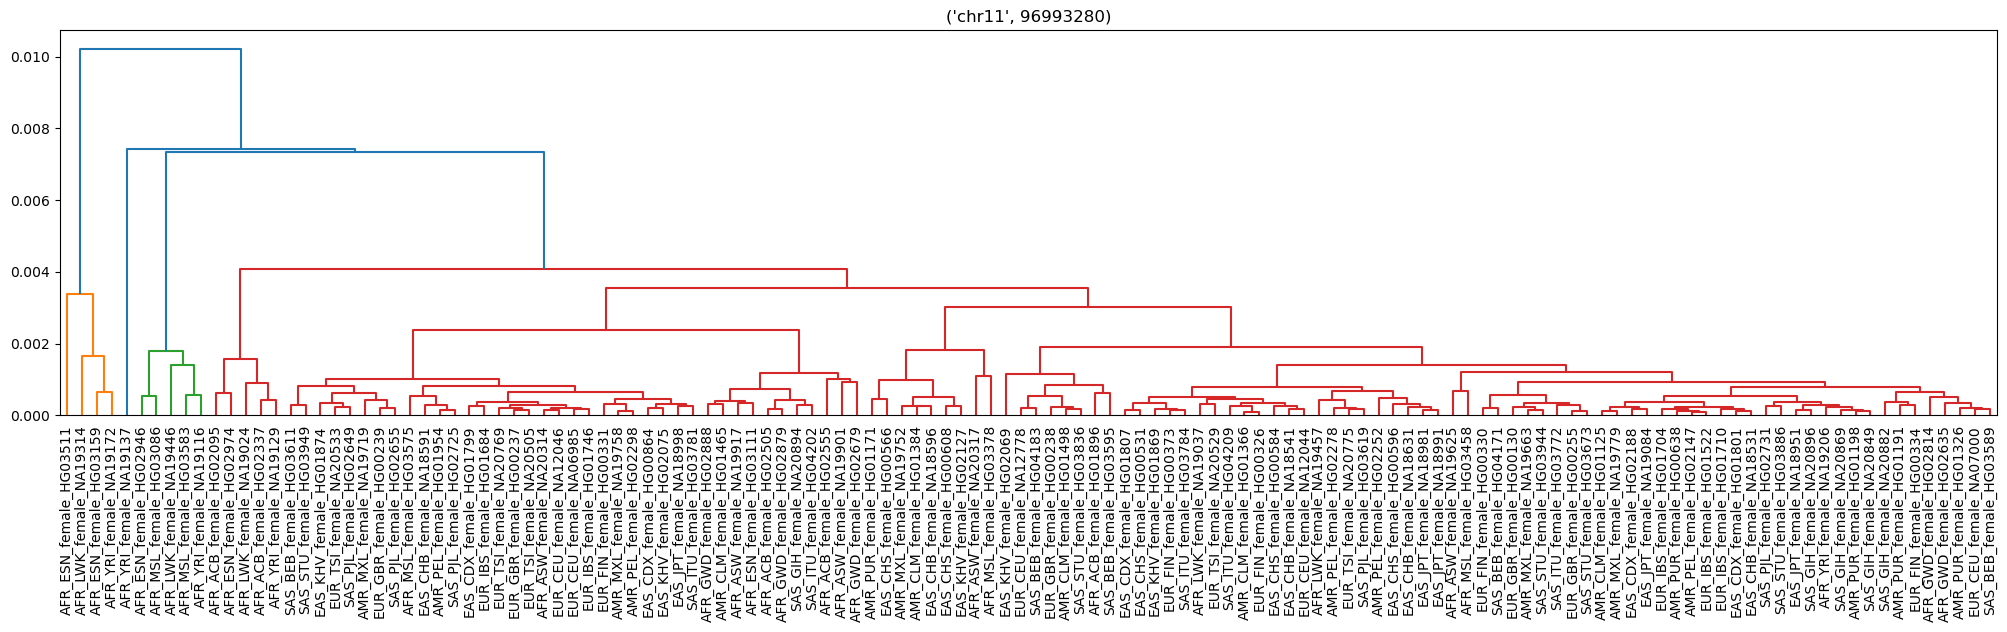

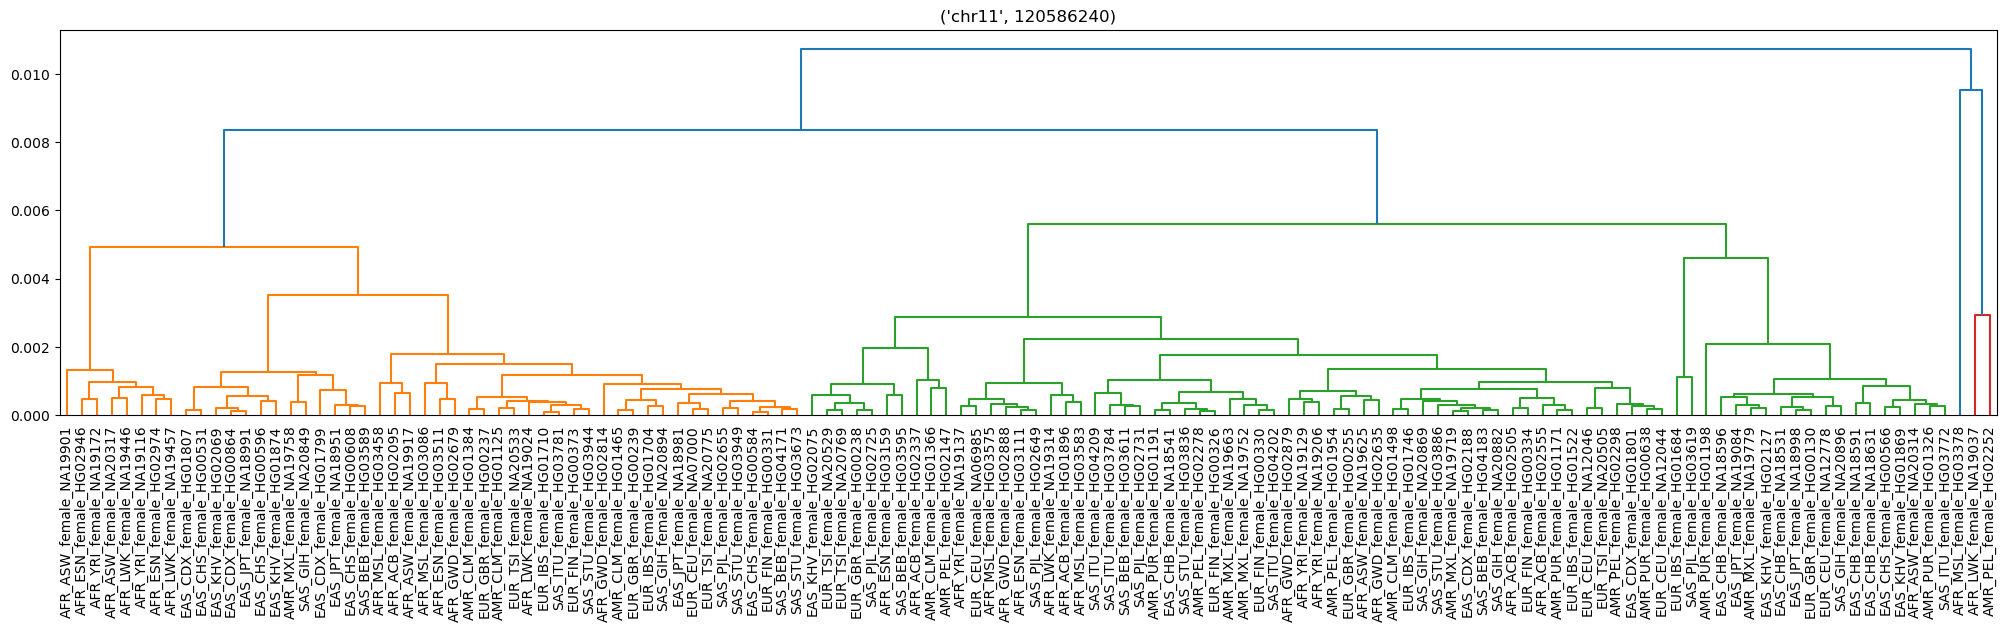

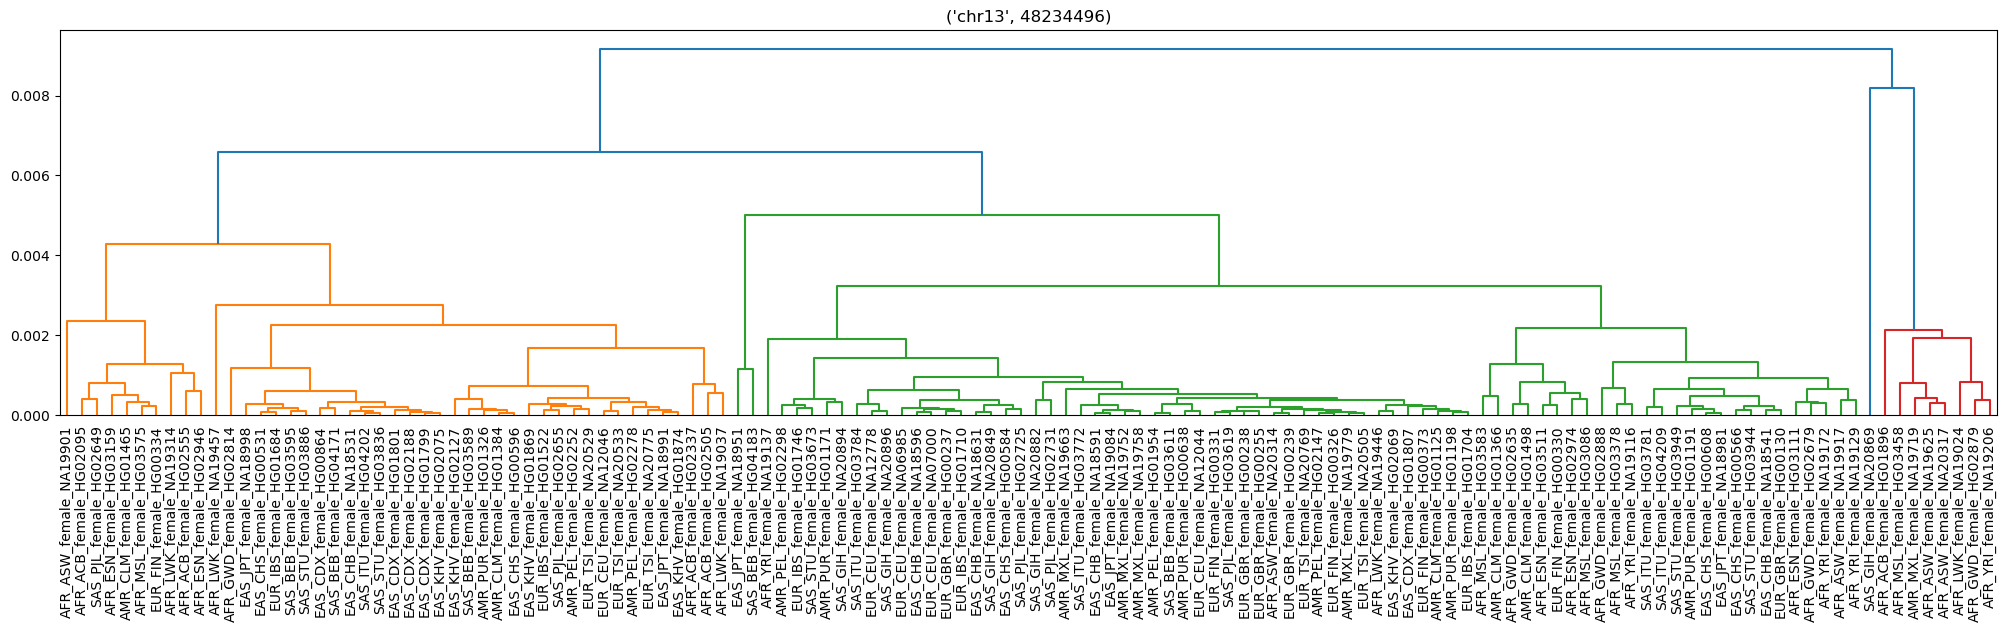

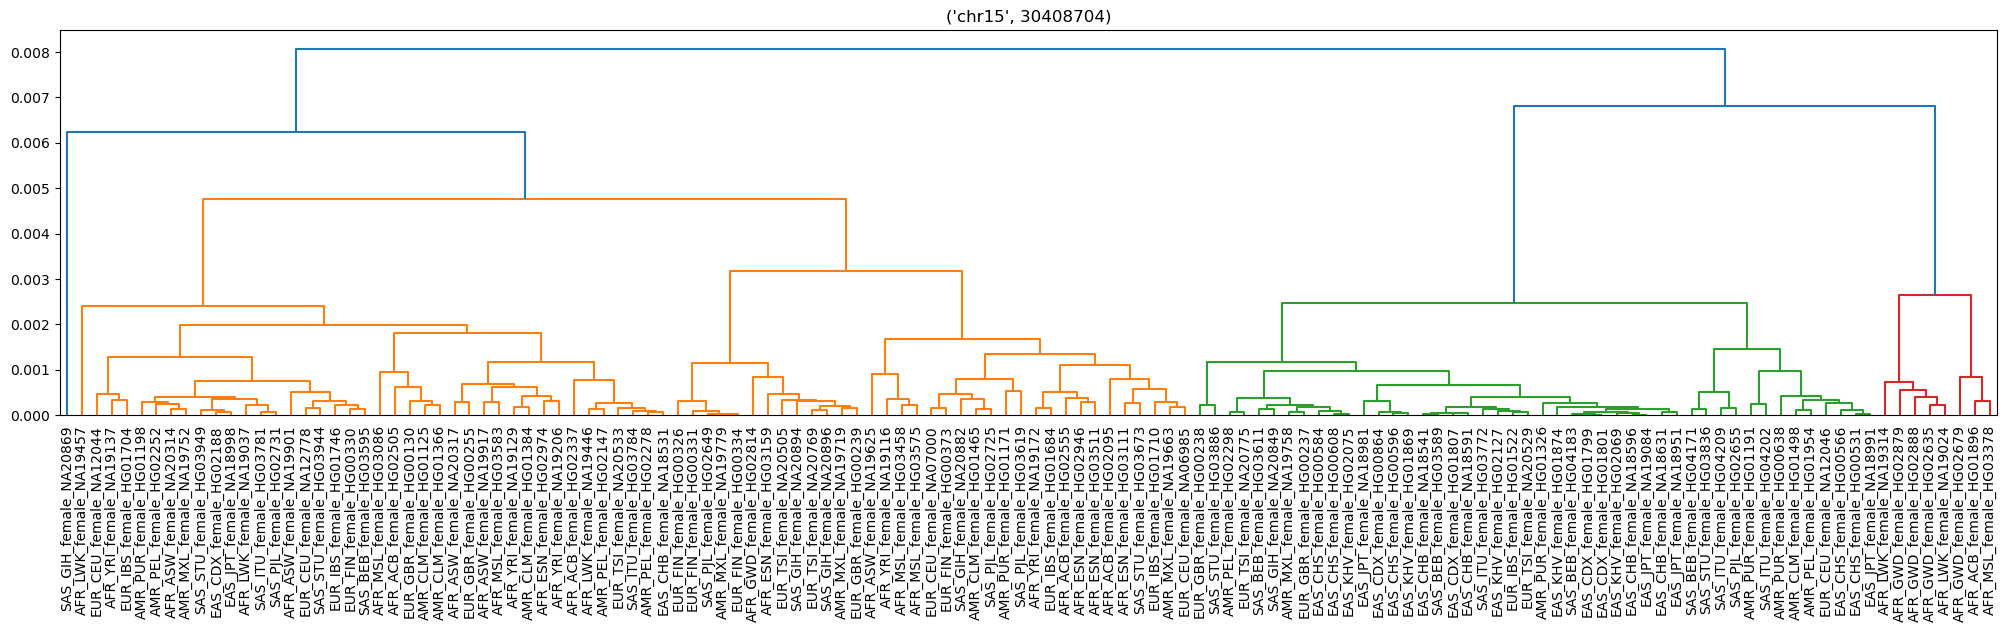

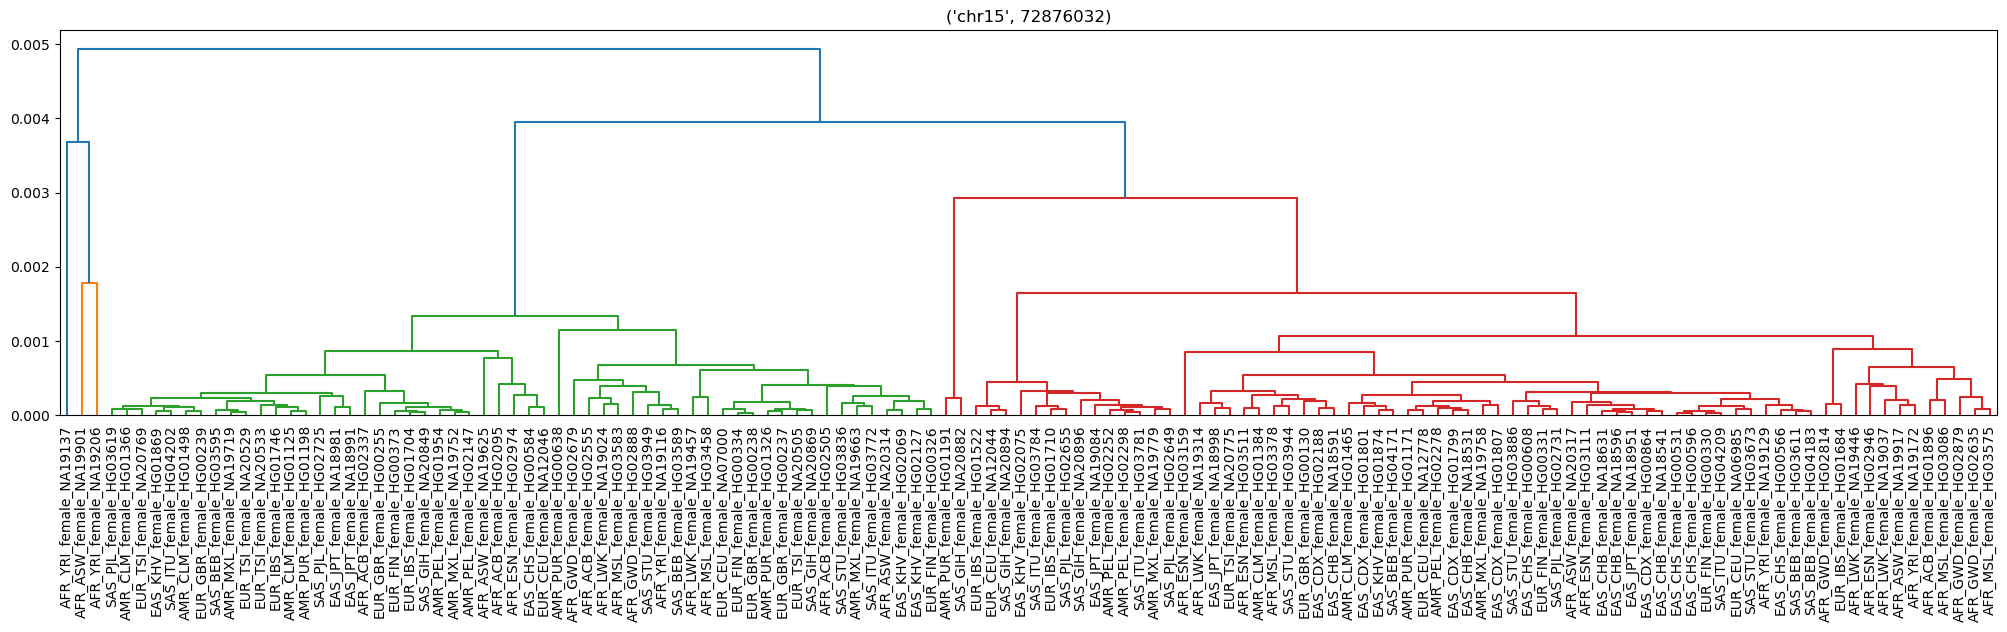

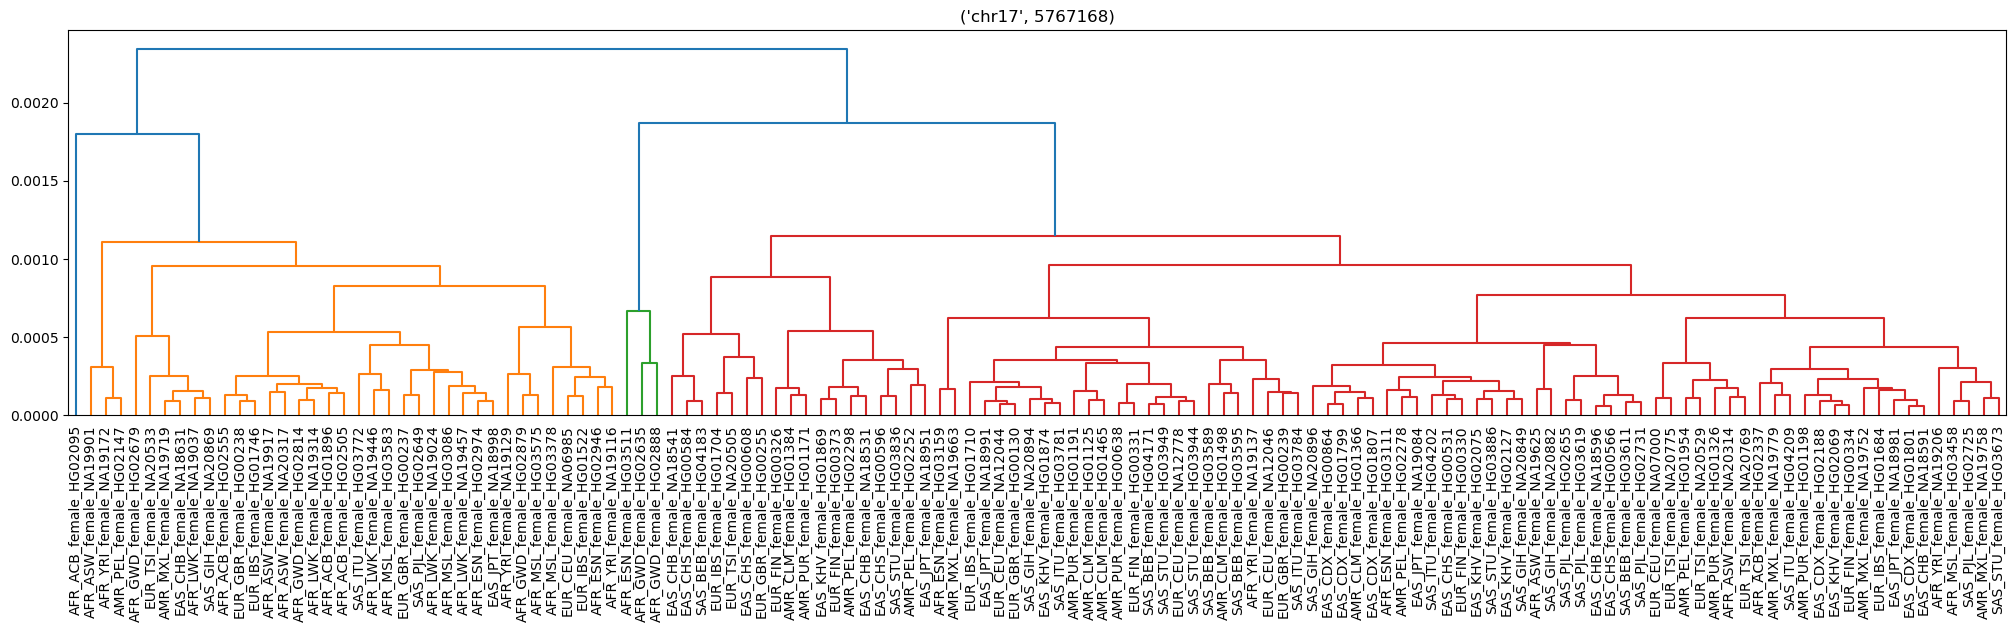

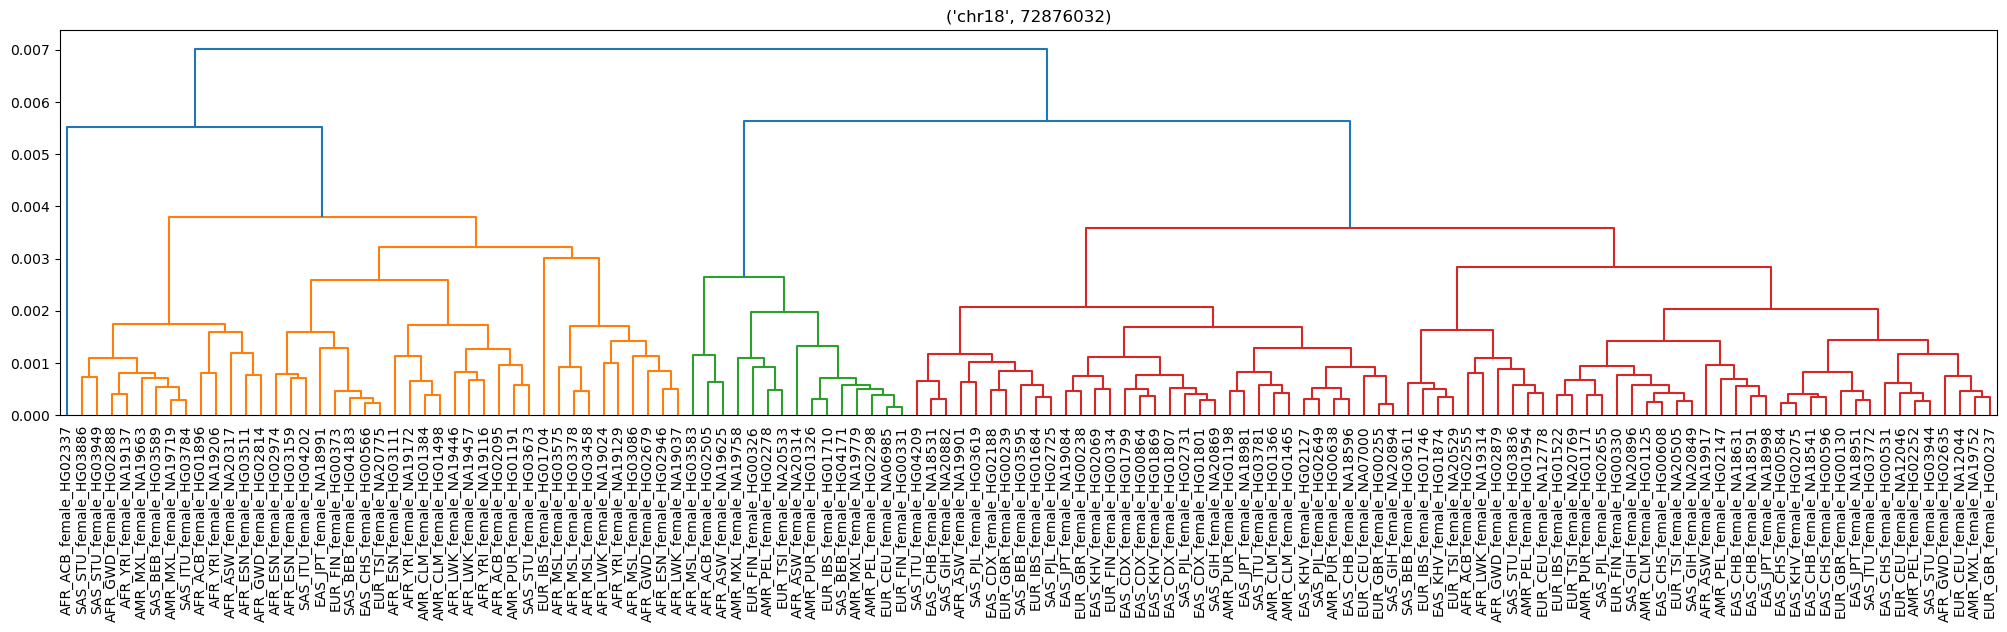

In [22]:
counts_df[counts_df.C0!=0.0][counts_df.C4 == 0.0][counts_df.C3 != 0.0]
for i in counts_df[counts_df.C0!=0.0][counts_df.C4 == 0.0][counts_df.C3 != 0.0].index:
    get_window_dendrogram(i)
    plt.show()

In [23]:
counts_df.mean()

C0        0.641494
C1       55.155346
C2       65.475888
C3        8.153088
C4        0.549148
C5        0.025036
depth     0.028904
dtype: float64

In [24]:
counts_df[counts_df.C0==0.0].mean()

C0        0.000000
C1       34.577772
C2       83.800335
C3       10.869031
C4        0.718794
C5        0.034069
depth     0.027246
dtype: float64

In [25]:
counts_df[counts_df.C0!=0.0].mean()

C0         2.419505
C1       112.189628
C2        14.686533
C3         0.625387
C4         0.078947
C5         0.000000
depth      0.033500
dtype: float64

In [26]:
counts_df[counts_df.C5!=0.0].mean()

C0        0.000000
C1        4.666667
C2       34.333333
C3       44.333333
C4        6.000000
C5       40.666667
depth     0.000937
dtype: float64

In [27]:
counts_df[counts_df.C5==0.0][counts_df.C4!=0.0].mean()

/scratch/egilbertson/ipykernel_19897/416014296.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts_df[counts_df.C5==0.0][counts_df.C4!=0.0].mean()


C0        0.035088
C1       22.824561
C2       36.736842
C3       23.771930
C4       46.631579
C5        0.000000
depth     0.004796
dtype: float64

In [28]:
idw = counts_df[(counts_df.C0==1 )|(counts_df.C1==1)|(counts_df.C2==1)|(counts_df.C3==1)|(counts_df.C4==1)|(counts_df.C5==1)]

In [29]:
dataframe.loc[[idw.index[0]]].where(dataframe.loc[[idw.index[0]]]=='C0').dropna(how='all').dropna(axis=1).columns[0]

'AFR_ASW_female_NA19901'

In [40]:
idw_list = []
for r in idw.index:
    row = dataframe.loc[[r]]
    ind = row.where(row=='C0').dropna(how='all').dropna(axis=1).dropna(axis=1).columns[0]
    idw_list.append(ind)

In [42]:
len(idw_list)

1251

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
(chr1, 3670016)                   False                   False   

                 AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
(chr1, 3670016)                   False                   False   

                 AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
(chr1, 3670016)                   False                   False   

                 AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
(chr1, 3670016)                    True                   False   

                 AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
(chr1, 3670016)                   False                   False  ...   

                 SAS_PJL_female_HG03619  SAS_STU_female_HG03673  \
(chr1, 3670016)                   False                   False   

                 SAS_STU_female_HG03836  SAS_STU_female_HG03886  \
(chr1, 3670016)                   False                   False   

                 SAS_STU_female_HG03944  SAS_STU_female_HG03949  coord_0  \
(chr1, 3670016)                   False                   False    False   

                 coord_1  coord_2  coord_3  
(chr1, 3670016)    False    False    False  

[1 rows x 134 columns]

In [43]:
idw['individual'] = idw_list

/scratch/egilbertson/ipykernel_19897/797250996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idw['individual'] = idw_list


In [52]:
idw.individual.value_counts().head(n=50)


AFR_LWK_female_NA19446    24
AFR_ASW_female_NA19901    23
AFR_MSL_female_HG03086    23
AFR_ASW_female_NA19917    22
AFR_LWK_female_NA19314    22
AFR_ACB_female_HG01896    21
AFR_GWD_female_HG02679    21
AFR_MSL_female_HG03378    21
AFR_LWK_female_NA19457    20
AFR_GWD_female_HG02635    20
AFR_MSL_female_HG03458    19
AFR_ESN_female_HG02974    19
AFR_GWD_female_HG02888    19
AFR_LWK_female_NA19037    19
SAS_ITU_female_HG03772    18
AFR_ACB_female_HG02555    18
AFR_YRI_female_NA19172    17
AFR_ESN_female_HG03111    17
AFR_MSL_female_HG03583    17
AFR_MSL_female_HG03575    17
AFR_YRI_female_NA19116    16
SAS_STU_female_HG03673    16
AFR_LWK_female_NA19024    16
AFR_GWD_female_HG02879    15
EAS_KHV_female_HG01874    15
AFR_ESN_female_HG03159    15
AFR_ACB_female_HG02337    14
AFR_GWD_female_HG02814    14
EAS_KHV_female_HG02069    14
SAS_PJL_female_HG02655    14
SAS_BEB_female_HG03611    13
AMR_PUR_female_HG01191    13
AMR_PUR_female_HG01326    13
AFR_ACB_female_HG02505    13
EAS_CDX_female

(array([541., 281., 133.,  79.,  41.,  32.,  33.,  22.,  17.,  14.,  14.,
          2.,   3.,   7.,   2.,   4.,   5.,   0.,   1.,   1.,   1.,   0.,
          0.,   1.,   7.,   4.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.0006653 , 0.01331174, 0.02595819, 0.03860463, 0.05125107,
        0.06389751, 0.07654395, 0.0891904 , 0.10183684, 0.11448328,
        0.12712972, 0.13977616, 0.15242261, 0.16506905, 0.17771549,
        0.19036193, 0.20300837, 0.21565481, 0.22830126, 0.2409477 ,
        0.25359414, 0.26624058, 0.27888702, 0.29153347, 0.30417991,
        0.31682635, 0.32947279, 0.34211923, 0.35476568, 0.36741212,
        0.38005856, 0.392705  , 0.40535144, 0.41799789, 0.43064433,
        0.44329077, 0.45593721, 0.46858365, 0.48123009, 0.49387654,
        0.50652298, 0.51916942, 0.53181586, 0.5444623 , 0.55710875,
        0.56975519, 0.58240163, 0.59504807, 0.

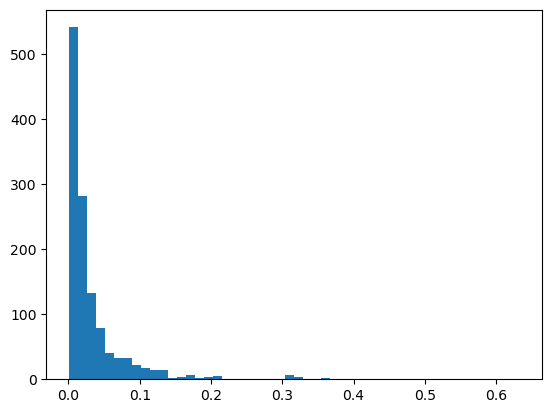

In [30]:
plt.hist(idw.depth, bins=50)

# Heat map plotting

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


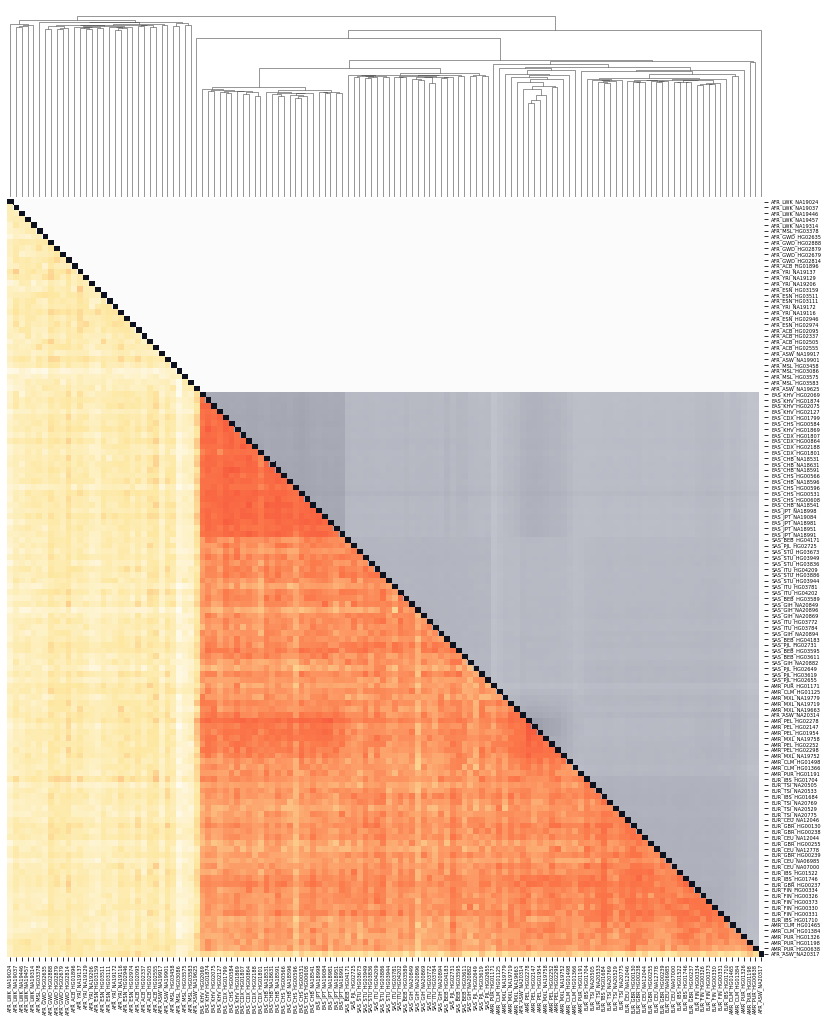

In [7]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle

# colormaps
cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'],float_list=[0, 0.5,0.99, 1])
cmap_3d = get_continuous_cmap(["#c5000e",'f44132','#fc774a',"fee8a1","#fffdf2"])
#cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'])


# Linkage and cluster baseds on sequence
linkage = hc.linkage(sp.distance.squareform(matrix_seq), method='complete',optimal_ordering=True) # complete, single, average, weighted
g = sns.clustermap(matrix_seq*2**20, row_linkage=linkage,square=True, figsize=(15,15),col_linkage=linkage, cmap = cmap_seq, vmin=150, vmax=1100, yticklabels=True, xticklabels=True)

# Flip
g.ax_heatmap.invert_xaxis()
g.ax_heatmap.invert_yaxis()
g.ax_row_dendrogram.invert_yaxis()
g.ax_col_dendrogram.invert_xaxis()
_ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 5)

# Color bottom triangle based on 3d genome

order = g.dendrogram_col.reordered_ind
order = [all_indivs[x] for x in order]
order = ["_".join(np.array(x.split("_"))[[0,1,3]]) if "_" in x else x for x in order]

ax = g.ax_heatmap

for i,indiv1 in enumerate(order):
    for j,indiv2 in enumerate(order):
        if i > j:
            _ = ax.add_patch(Rectangle((i-.03, j), 1.2, 1, fc=cmap_3d((matrix_3d.loc[indiv1,indiv2]-0.00043)/(0.00476-0.00043)),linewidth=0,ec=None))

g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
#plt.savefig("heatmap3dandSeq.pdf");
#plt.savefig("/home/mcarthe/heatmap3dandSeq.pdf");

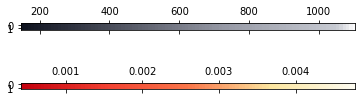

In [8]:
cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'],float_list=[0, 0.6,0.95, 1])

fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(6,2));

ax[0].matshow(np.array([np.linspace(150,1100,100),np.linspace(150,1100,100)]), cmap=cmap_seq, vmin=150, vmax=1100);
# vrange: 150 - 1100
#(m - rmin)/(rmax - rmin) * (tmax - tmin) + tmin
ax[0].set_xticks([((x - 150)/(1100 - 150) * 99) for x in np.arange(200,1100,200)]);
ax[0].set_xticklabels(np.arange(200,1100,200));

ax[1].matshow(np.array([np.linspace(0,1,100),np.linspace(0,1,100)]), cmap= cmap_3d);
# vrange = 0.00043 - 0.00476
ax[1].set_xticks([((x - 0.00043)/(0.00476 - 0.00043) * 99) for x in np.arange(0.001,0.00476,0.001)]);
ax[1].set_xticklabels(np.arange(0.001,0.00476,0.001));

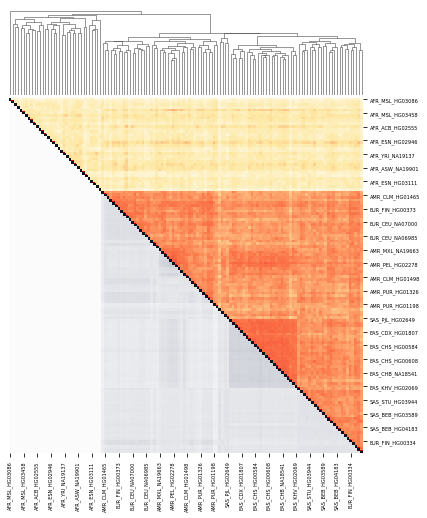

In [10]:
# Visualize together

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle

# colormaps
cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'],float_list=[0, 0.40,0.58, 1])
cmap_3d = get_continuous_cmap(["#c5000e",'f44132','#fc774a',"fee8a1","#fffdf2"])

# Linkage and cluster baseds on sequence
linkage = hc.linkage(sp.distance.squareform(matrix_3d), method='complete',optimal_ordering=True) # complete, single, average, weighted
g = sns.clustermap(matrix_3d, row_linkage=linkage, col_linkage=linkage, cmap = cmap_3d,figsize=(8,8), vmin=0.00043, vmax=0.00476)

#g.ax_col_dendrogram.invert_xaxis()
_ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 5)

# Color bottom triangle based on 3d genome

order = g.dendrogram_col.reordered_ind
order = [all_indivs[x] for x in order]
order = ["_".join(np.array(x.split("_"))[[0,1,3]]) if "_" in x else x for x in order]

ax = g.ax_heatmap

for i,indiv1 in enumerate(order):
    for j,indiv2 in enumerate(order):
        if i >= j:
            _ = ax.add_patch(Rectangle((j,i-0.03), 1, 1.2, fc=cmap_seq(((2**20*matrix_seq.loc[indiv1,indiv2])-150)/(1100-150)),linewidth=0,ec=None))
        #elif i == j:
            
            
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
#plt.savefig("/home/mcarthe/heatmap3dandSeq_clusterby3d.pdf");


In [119]:
!pwd

/wynton/group/capra/projects/modern_human_3Dgenome/bin/activeNotebooks


In [147]:
np.nanmean(matrix_seq)

0.0010272449125470645

In [28]:
matrix_seq

AMR_PUR_HG01171  EAS_CDX_HG01801  EUR_GBR_HG00255  \
AMR_PUR_HG01171         0.000000         0.000962         0.000906   
EAS_CDX_HG01801         0.000962         0.000000         0.000918   
EUR_GBR_HG00255         0.000906         0.000918         0.000000   
AMR_MXL_NA19719         0.000926         0.000894         0.000879   
AMR_MXL_NA19663         0.000929         0.000876         0.000893   
...                          ...              ...              ...   
SAS_ITU_HG03772         0.000948         0.000876         0.000886   
EUR_CEU_NA12778         0.000901         0.000921         0.000813   
AFR_GWD_HG02888         0.001227         0.001241         0.001238   
SAS_STU_HG03673         0.000955         0.000883         0.000892   
SAS_BEB_HG03595         0.000945         0.000861         0.000888   

                 AMR_MXL_NA19719  AMR_MXL_NA19663  EUR_CEU_NA07000  \
AMR_PUR_HG01171         0.000926         0.000929         0.000906   
EAS_CDX_HG01801         0.000894         0.000876         0.000919   
EUR_GBR_HG00255         0.000879         0.000893         0.000815   
AMR_MXL_NA19719         0.000000         0.000843         0.000870   
AMR_MXL_NA19663         0.000843         0.000000         0.000887   
...                          ...              ...              ...   
SAS_ITU_HG03772         0.000900         0.000902         0.000891   
EUR_CEU_NA12778         0.000873         0.000890         0.000811   
AFR_GWD_HG02888         0.001234         0.001237         0.001246   
SAS_STU_HG03673         0.000911         0.000908         0.000890   
SAS_BEB_HG03595         0.000895         0.000895         0.000883   

                 SAS_GIH_NA20869  EUR_GBR_HG00130  AFR_LWK_NA19314  \
AMR_PUR_HG01171         0.000935         0.000910         0.001214   
EAS_CDX_HG01801         0.000879         0.000917         0.001228   
EUR_GBR_HG00255         0.000876         0.000810         0.001230   
AMR_MXL_NA19719         0.000898         0.000870         0.001228   
AMR_MXL_NA19663         0.000895         0.000886         0.001224   
...                          ...              ...              ...   
SAS_ITU_HG03772         0.000838         0.000884         0.001223   
EUR_CEU_NA12778         0.000875         0.000812         0.001232   
AFR_GWD_HG02888         0.001233         0.001234         0.001228   
SAS_STU_HG03673         0.000845         0.000889         0.001230   
SAS_BEB_HG03595         0.000849         0.000885         0.001227   

                 SAS_PJL_HG02649  ...  AFR_ESN_HG03159  AMR_CLM_HG01465  \
AMR_PUR_HG01171         0.000935  ...         0.001234         0.000909   
EAS_CDX_HG01801         0.000899  ...         0.001250         0.000907   
EUR_GBR_HG00255         0.000861  ...         0.001258         0.000842   
AMR_MXL_NA19719         0.000891  ...         0.001248         0.000862   
AMR_MXL_NA19663         0.000898  ...         0.001245         0.000874   
...                          ...  ...              ...              ...   
SAS_ITU_HG03772         0.000854  ...         0.001248         0.000898   
EUR_CEU_NA12778         0.000857  ...         0.001260         0.000841   
AFR_GWD_HG02888         0.001236  ...         0.001205         0.001233   
SAS_STU_HG03673         0.000862  ...         0.001253         0.000898   
SAS_BEB_HG03595         0.000856  ...         0.001246         0.000888   

                 EAS_KHV_HG02069  AFR_MSL_HG03086  EAS_CHB_NA18541  \
AMR_PUR_HG01171         0.000966         0.001245         0.000954   
EAS_CDX_HG01801         0.000758         0.001258         0.000759   
EUR_GBR_HG00255         0.000926         0.001261         0.000913   
AMR_MXL_NA19719         0.000895         0.001255         0.000883   
AMR_MXL_NA19663         0.000883         0.001255         0.000868   
...                          ...              ...              ...   
SAS_ITU_HG03772         0.000878         0.001258         0.000881   
EUR_CEU_NA12778         0.000923 